<img width="800px" src="../fidle/img/00-Fidle-header-01.svg"></img>

# <!-- TITLE --> [VAE1] - First VAE, using functional API (MNIST dataset)
<!-- DESC --> Construction and training of a VAE, using functional APPI, with a latent space of small dimension.

<!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->

## Objectives :
 - Understanding and implementing a **variational autoencoder** neurals network (VAE)
 - Understanding **Keras functional API**

The calculation needs being important, it is preferable to use a very simple dataset such as MNIST to start with.  
...MNIST with a small scale if you haven't a GPU ;-)

## What we're going to do :

 - Defining a VAE model
 - Build the model
 - Train it
 - Have a look on the train process

## Acknowledgements :
Thanks to **François Chollet** who is at the base of this example (and the creator of Keras !!).  
See : https://keras.io/examples/generative/vae


## Step 1 - Init python stuff

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import TensorBoard

from modules.layers    import SamplingLayer, VariationalLossLayer
from modules.callbacks import ImagesCallback, BestModelCallback
from modules.datagen   import MNIST

import sys
sys.path.append('..')
import fidle.pwk as pwk

run_dir = './run/VAE1.001'
datasets_dir = pwk.init('VAE1', run_dir)


**\*\* Overrided parameters : \*\***

run_dir              : ./run/VAE1_done


<br>**FIDLE 2020 - Practical Work Module**

Version              : 2.0.22
Notebook id          : VAE1
Run time             : Monday 22 March 2021, 14:39:46
TensorFlow version   : 2.4.0
Keras version        : 2.4.0
Datasets dir         : /gpfswork/rech/mlh/uja62cb/datasets
Run dir              : ./run/VAE1_done
Update keras cache   : False
Save figs            : True
Path figs            : ./run/VAE1_done/figs


## Step 2 - Parameters
`scale` : With scale=1, we need 1'30s on a GPU V100 ...and >20' on a CPU !\
`latent_dim` : 2 dimensions is small, but usefull to draw !


`loss_weights` : Our **loss function** is the weighted sum of two loss:
 - `r_loss` which measures the loss during reconstruction.  
 - `kl_loss` which measures the dispersion.  

The weights are defined by: `loss_weights=[k1,k2]` where : `total_loss = k1*r_loss + k2*kl_loss`  
In practice, a value of \[1,5e-4\] gives good results here.


In [2]:
latent_dim    = 2
loss_weights  = [1,5e-4]

scale         = .1
seed          = 123

batch_size    = 64
epochs        = 10

Override parameters (batch mode) - Just forget this cell

In [3]:
pwk.override('latent_dim', 'loss_weights', 'scale', 'seed', 'batch_size', 'epochs')

**\*\* Overrided parameters : \*\***

latent_dim           : 2
loss_weights         : [1, 0.0001]
scale                : 1
seed                 : 123
batch_size           : 64
epochs               : 10


## Step 3 - Prepare data
`MNIST.get_data()` return : `x_train,y_train, x_test,y_test`,  \
but we only need x_train for our training.

Seeded (123)


Dataset loaded.
Concatenated.
Shuffled.
rescaled (1).
Normalized.
Reshaped.
splited (1).


x_train shape is  :  (70000, 28, 28, 1)
x_test  shape is  :  (0, 28, 28, 1)
y_train shape is  :  (70000,)
y_test  shape is  :  (0,)
Blake2b digest is :  0c903710d4d28b01c174


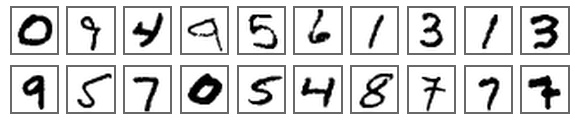

In [4]:
x_data, y_data, _,_ = MNIST.get_data(seed=seed, scale=scale, train_prop=1 )

pwk.plot_images(x_data[:20], None, indices='all', columns=10, x_size=1,y_size=1,y_padding=0, save_as='01-original')

## Step 4 - Build model
In this example, we will use the **functional API.**  
For this, we will use two custom layers :
 - `SamplingLayer`, which generates a vector z from the parameters z_mean and z_log_var - See : [SamplingLayer.py](./modules/layers/SamplingLayer.py)
 - `VariationalLossLayer`, which allows us to calculate the loss function, loss - See : [VariationalLossLayer.py](./modules/layers/VariationalLossLayer.py)

#### Encoder

In [5]:
inputs    = keras.Input(shape=(28, 28, 1))
x         = layers.Conv2D(32, 3, strides=1, padding="same", activation="relu")(inputs)
x         = layers.Conv2D(64, 3, strides=2, padding="same", activation="relu")(x)
x         = layers.Conv2D(64, 3, strides=2, padding="same", activation="relu")(x)
x         = layers.Conv2D(64, 3, strides=1, padding="same", activation="relu")(x)
x         = layers.Flatten()(x)
x         = layers.Dense(16, activation="relu")(x)

z_mean    = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z         = SamplingLayer()([z_mean, z_log_var])

encoder = keras.Model(inputs, [z_mean, z_log_var, z], name="encoder")
# encoder.summary()

#### Decoder

In [6]:
inputs  = keras.Input(shape=(latent_dim,))
x       = layers.Dense(7 * 7 * 64, activation="relu")(inputs)
x       = layers.Reshape((7, 7, 64))(x)
x       = layers.Conv2DTranspose(64, 3, strides=1, padding="same", activation="relu")(x)
x       = layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu")(x)
x       = layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu")(x)
outputs = layers.Conv2DTranspose(1,  3, padding="same", activation="sigmoid")(x)

decoder = keras.Model(inputs, outputs, name="decoder")

# decoder.summary()

#### VAE

We will calculate the loss with a specific layer: `VariationalLossLayer` - See : [VariationalLossLayer.py](./modules/layers/VariationalLossLayer.py)

In [7]:

inputs = keras.Input(shape=(28, 28, 1))

z_mean, z_log_var, z = encoder(inputs)
outputs              = decoder(z)

outputs = VariationalLossLayer(loss_weights=loss_weights)([inputs, z_mean, z_log_var, outputs])

vae=keras.Model(inputs,outputs)

vae.compile(optimizer='adam', loss=None)

## Step 5 - Train
### 5.1 - Using two nice custom callbacks :-)
Two custom callbacks are used:
 - `ImagesCallback` : qui va sauvegarder des images durant l'apprentissage - See [ImagesCallback.py](./modules/callbacks/ImagesCallback.py)
 - `BestModelCallback` : qui sauvegardera le meilleur model - See [BestModelCallback.py](./modules/callbacks/BestModelCallback.py)

In [8]:
callback_images      = ImagesCallback(x=x_data, z_dim=latent_dim, nb_images=5, from_z=True, from_random=True, run_dir=run_dir)
callback_bestmodel   = BestModelCallback( run_dir + '/models/best_model.h5' )
callback_tensorboard = TensorBoard(log_dir=run_dir + '/logs', histogram_freq=1)

callbacks_list = [callback_images, callback_bestmodel]

### 5.2 - Let's train !
With `scale=1`, need 1'15 on a GPU (V100 at IDRIS) ...or 20' on a CPU  

In [9]:
pwk.chrono_start()

history = vae.fit(x_data, epochs=epochs, batch_size=batch_size, callbacks=callbacks_list,)

pwk.chrono_show()

Epoch 1/10


   1/1094 [..............................] - ETA: 1:48:58 - loss: 0.6929 - r_loss: 0.6929 - kl_loss: 7.6395e-08

  12/1094 [..............................] - ETA: 5s - loss: 0.6336 - r_loss: 0.6318 - kl_loss: 0.0019         

  23/1094 [..............................] - ETA: 5s - loss: 0.5588 - r_loss: 0.5576 - kl_loss: 0.0011

  34/1094 [..............................] - ETA: 4s - loss: 0.5009 - r_loss: 0.5001 - kl_loss: 7.9498e-04

  46/1094 [>.............................] - ETA: 4s - loss: 0.4505 - r_loss: 0.4498 - kl_loss: 6.3566e-04

  58/1094 [>.............................] - ETA: 4s - loss: 0.4141 - r_loss: 0.4134 - kl_loss: 7.2735e-04

  70/1094 [>.............................] - ETA: 4s - loss: 0.3890 - r_loss: 0.3882 - kl_loss: 7.7291e-04

  82/1094 [=>............................] - ETA: 4s - loss: 0.3707 - r_loss: 0.3699 - kl_loss: 8.4573e-04

  94/1094 [=>............................] - ETA: 4s - loss: 0.3565 - r_loss: 0.3555 - kl_loss: 0.0010    

 106/1094 [=>............................] - ETA: 4s - loss: 0.3458 - r_loss: 0.3447 - kl_loss: 0.0011

 118/1094 [==>...........................] - ETA: 4s - loss: 0.3365 - r_loss: 0.3353 - kl_loss: 0.0012

 130/1094 [==>...........................] - ETA: 4s - loss: 0.3287 - r_loss: 0.3275 - kl_loss: 0.0012

 142/1094 [==>...........................] - ETA: 4s - loss: 0.3220 - r_loss: 0.3207 - kl_loss: 0.0013

 154/1094 [===>..........................] - ETA: 4s - loss: 0.3162 - r_loss: 0.3149 - kl_loss: 0.0013

 166/1094 [===>..........................] - ETA: 4s - loss: 0.3109 - r_loss: 0.3096 - kl_loss: 0.0013

 178/1094 [===>..........................] - ETA: 4s - loss: 0.3065 - r_loss: 0.3051 - kl_loss: 0.0013

 190/1094 [====>.........................] - ETA: 4s - loss: 0.3027 - r_loss: 0.3013 - kl_loss: 0.0014

 202/1094 [====>.........................] - ETA: 4s - loss: 0.2989 - r_loss: 0.2975 - kl_loss: 0.0014

 214/1094 [====>.........................] - ETA: 3s - loss: 0.2956 - r_loss: 0.2942 - kl_loss: 0.0014

 226/1094 [=====>........................] - ETA: 3s - loss: 0.2925 - r_loss: 0.2911 - kl_loss: 0.0015

 238/1094 [=====>........................] - ETA: 3s - loss: 0.2896 - r_loss: 0.2882 - kl_loss: 0.0015

 250/1094 [=====>........................] - ETA: 3s - loss: 0.2869 - r_loss: 0.2854 - kl_loss: 0.0015

 262/1094 [======>.......................] - ETA: 3s - loss: 0.2846 - r_loss: 0.2831 - kl_loss: 0.0015

 274/1094 [======>.......................] - ETA: 3s - loss: 0.2823 - r_loss: 0.2807 - kl_loss: 0.0016

 286/1094 [======>.......................] - ETA: 3s - loss: 0.2802 - r_loss: 0.2786 - kl_loss: 0.0016

 298/1094 [=======>......................] - ETA: 3s - loss: 0.2781 - r_loss: 0.2764 - kl_loss: 0.0016

 310/1094 [=======>......................] - ETA: 3s - loss: 0.2761 - r_loss: 0.2744 - kl_loss: 0.0016

 322/1094 [=======>......................] - ETA: 3s - loss: 0.2742 - r_loss: 0.2726 - kl_loss: 0.0017

 334/1094 [========>.....................] - ETA: 3s - loss: 0.2726 - r_loss: 0.2709 - kl_loss: 0.0017

 346/1094 [========>.....................] - ETA: 3s - loss: 0.2707 - r_loss: 0.2690 - kl_loss: 0.0017

 358/1094 [========>.....................] - ETA: 3s - loss: 0.2690 - r_loss: 0.2673 - kl_loss: 0.0017

 370/1094 [=========>....................] - ETA: 3s - loss: 0.2675 - r_loss: 0.2657 - kl_loss: 0.0017

 382/1094 [=========>....................] - ETA: 3s - loss: 0.2661 - r_loss: 0.2643 - kl_loss: 0.0017

 394/1094 [=========>....................] - ETA: 3s - loss: 0.2648 - r_loss: 0.2630 - kl_loss: 0.0017

 406/1094 [==========>...................] - ETA: 3s - loss: 0.2636 - r_loss: 0.2618 - kl_loss: 0.0018

 418/1094 [==========>...................] - ETA: 3s - loss: 0.2623 - r_loss: 0.2606 - kl_loss: 0.0018

 430/1094 [==========>...................] - ETA: 2s - loss: 0.2612 - r_loss: 0.2595 - kl_loss: 0.0018

 442/1094 [===========>..................] - ETA: 2s - loss: 0.2601 - r_loss: 0.2583 - kl_loss: 0.0018

 454/1094 [===========>..................] - ETA: 2s - loss: 0.2590 - r_loss: 0.2573 - kl_loss: 0.0018

 466/1094 [===========>..................] - ETA: 2s - loss: 0.2580 - r_loss: 0.2562 - kl_loss: 0.0018

 478/1094 [============>.................] - ETA: 2s - loss: 0.2570 - r_loss: 0.2552 - kl_loss: 0.0018

 490/1094 [============>.................] - ETA: 2s - loss: 0.2560 - r_loss: 0.2542 - kl_loss: 0.0018

 502/1094 [============>.................] - ETA: 2s - loss: 0.2551 - r_loss: 0.2533 - kl_loss: 0.0018

 514/1094 [=============>................] - ETA: 2s - loss: 0.2542 - r_loss: 0.2524 - kl_loss: 0.0018

 526/1094 [=============>................] - ETA: 2s - loss: 0.2534 - r_loss: 0.2516 - kl_loss: 0.0018

 538/1094 [=============>................] - ETA: 2s - loss: 0.2525 - r_loss: 0.2507 - kl_loss: 0.0018

 550/1094 [==============>...............] - ETA: 2s - loss: 0.2517 - r_loss: 0.2499 - kl_loss: 0.0018

 562/1094 [==============>...............] - ETA: 2s - loss: 0.2509 - r_loss: 0.2491 - kl_loss: 0.0018

 574/1094 [==============>...............] - ETA: 2s - loss: 0.2502 - r_loss: 0.2484 - kl_loss: 0.0018

 586/1094 [===============>..............] - ETA: 2s - loss: 0.2494 - r_loss: 0.2476 - kl_loss: 0.0018

 598/1094 [===============>..............] - ETA: 2s - loss: 0.2487 - r_loss: 0.2469 - kl_loss: 0.0018

 610/1094 [===============>..............] - ETA: 2s - loss: 0.2479 - r_loss: 0.2461 - kl_loss: 0.0018

 622/1094 [================>.............] - ETA: 2s - loss: 0.2472 - r_loss: 0.2454 - kl_loss: 0.0018

 634/1094 [================>.............] - ETA: 2s - loss: 0.2466 - r_loss: 0.2448 - kl_loss: 0.0018

 646/1094 [================>.............] - ETA: 2s - loss: 0.2460 - r_loss: 0.2442 - kl_loss: 0.0018

 658/1094 [=================>............] - ETA: 1s - loss: 0.2453 - r_loss: 0.2435 - kl_loss: 0.0018

 670/1094 [=================>............] - ETA: 1s - loss: 0.2447 - r_loss: 0.2429 - kl_loss: 0.0018

 682/1094 [=================>............] - ETA: 1s - loss: 0.2441 - r_loss: 0.2423 - kl_loss: 0.0018

 694/1094 [==================>...........] - ETA: 1s - loss: 0.2435 - r_loss: 0.2417 - kl_loss: 0.0018

 706/1094 [==================>...........] - ETA: 1s - loss: 0.2429 - r_loss: 0.2411 - kl_loss: 0.0018

 718/1094 [==================>...........] - ETA: 1s - loss: 0.2424 - r_loss: 0.2406 - kl_loss: 0.0018

 730/1094 [===================>..........] - ETA: 1s - loss: 0.2418 - r_loss: 0.2400 - kl_loss: 0.0018

 742/1094 [===================>..........] - ETA: 1s - loss: 0.2413 - r_loss: 0.2395 - kl_loss: 0.0018

 754/1094 [===================>..........] - ETA: 1s - loss: 0.2407 - r_loss: 0.2389 - kl_loss: 0.0018

 766/1094 [====================>.........] - ETA: 1s - loss: 0.2402 - r_loss: 0.2384 - kl_loss: 0.0018

 778/1094 [====================>.........] - ETA: 1s - loss: 0.2397 - r_loss: 0.2380 - kl_loss: 0.0018

 790/1094 [====================>.........] - ETA: 1s - loss: 0.2392 - r_loss: 0.2374 - kl_loss: 0.0018

 802/1094 [====================>.........] - ETA: 1s - loss: 0.2387 - r_loss: 0.2370 - kl_loss: 0.0018

 814/1094 [=====================>........] - ETA: 1s - loss: 0.2383 - r_loss: 0.2365 - kl_loss: 0.0018

 826/1094 [=====================>........] - ETA: 1s - loss: 0.2378 - r_loss: 0.2360 - kl_loss: 0.0018

 838/1094 [=====================>........] - ETA: 1s - loss: 0.2374 - r_loss: 0.2356 - kl_loss: 0.0018

 850/1094 [======================>.......] - ETA: 1s - loss: 0.2369 - r_loss: 0.2351 - kl_loss: 0.0018

 862/1094 [======================>.......] - ETA: 1s - loss: 0.2364 - r_loss: 0.2346 - kl_loss: 0.0018

 874/1094 [======================>.......] - ETA: 0s - loss: 0.2359 - r_loss: 0.2342 - kl_loss: 0.0018

 886/1094 [=======================>......] - ETA: 0s - loss: 0.2354 - r_loss: 0.2337 - kl_loss: 0.0018

 898/1094 [=======================>......] - ETA: 0s - loss: 0.2350 - r_loss: 0.2332 - kl_loss: 0.0018

 910/1094 [=======================>......] - ETA: 0s - loss: 0.2345 - r_loss: 0.2328 - kl_loss: 0.0018

 922/1094 [========================>.....] - ETA: 0s - loss: 0.2341 - r_loss: 0.2324 - kl_loss: 0.0017

 934/1094 [========================>.....] - ETA: 0s - loss: 0.2337 - r_loss: 0.2320 - kl_loss: 0.0017

 946/1094 [========================>.....] - ETA: 0s - loss: 0.2333 - r_loss: 0.2316 - kl_loss: 0.0017

 958/1094 [=========================>....] - ETA: 0s - loss: 0.2329 - r_loss: 0.2312 - kl_loss: 0.0017

 970/1094 [=========================>....] - ETA: 0s - loss: 0.2325 - r_loss: 0.2307 - kl_loss: 0.0017

 982/1094 [=========================>....] - ETA: 0s - loss: 0.2321 - r_loss: 0.2304 - kl_loss: 0.0017

 994/1094 [==========================>...] - ETA: 0s - loss: 0.2317 - r_loss: 0.2300 - kl_loss: 0.0017

1006/1094 [==========================>...] - ETA: 0s - loss: 0.2314 - r_loss: 0.2297 - kl_loss: 0.0017

1018/1094 [==========================>...] - ETA: 0s - loss: 0.2310 - r_loss: 0.2293 - kl_loss: 0.0017

1030/1094 [===========================>..] - ETA: 0s - loss: 0.2306 - r_loss: 0.2289 - kl_loss: 0.0017

1042/1094 [===========================>..] - ETA: 0s - loss: 0.2303 - r_loss: 0.2286 - kl_loss: 0.0017

1054/1094 [===========================>..] - ETA: 0s - loss: 0.2300 - r_loss: 0.2282 - kl_loss: 0.0017

1066/1094 [============================>.] - ETA: 0s - loss: 0.2296 - r_loss: 0.2279 - kl_loss: 0.0017

1078/1094 [============================>.] - ETA: 0s - loss: 0.2293 - r_loss: 0.2276 - kl_loss: 0.0017

1090/1094 [============================>.] - ETA: 0s - loss: 0.2290 - r_loss: 0.2273 - kl_loss: 0.0017

1094/1094 [==============================] - ETA: 0s - loss: 0.2289 - r_loss: 0.2272 - kl_loss: 0.0017

1094/1094 [==============================] - 11s 5ms/step - loss: 0.2289 - r_loss: 0.2272 - kl_loss: 0.0017


Epoch 2/10
   1/1094 [..............................] - ETA: 5s - loss: 0.2064 - r_loss: 0.2049 - kl_loss: 0.0015

  13/1094 [..............................] - ETA: 4s - loss: 0.1973 - r_loss: 0.1958 - kl_loss: 0.0015

  25/1094 [..............................] - ETA: 4s - loss: 0.1969 - r_loss: 0.1954 - kl_loss: 0.0016

  37/1094 [>.............................] - ETA: 4s - loss: 0.1962 - r_loss: 0.1946 - kl_loss: 0.0016

  49/1094 [>.............................] - ETA: 4s - loss: 0.1965 - r_loss: 0.1949 - kl_loss: 0.0015

  61/1094 [>.............................] - ETA: 4s - loss: 0.1962 - r_loss: 0.1947 - kl_loss: 0.0015

  73/1094 [=>............................] - ETA: 4s - loss: 0.1964 - r_loss: 0.1949 - kl_loss: 0.0015

  85/1094 [=>............................] - ETA: 4s - loss: 0.1965 - r_loss: 0.1949 - kl_loss: 0.0015

  97/1094 [=>............................] - ETA: 4s - loss: 0.1965 - r_loss: 0.1950 - kl_loss: 0.0015

 109/1094 [=>............................] - ETA: 4s - loss: 0.1965 - r_loss: 0.1950 - kl_loss: 0.0015

 121/1094 [==>...........................] - ETA: 4s - loss: 0.1968 - r_loss: 0.1953 - kl_loss: 0.0015

 133/1094 [==>...........................] - ETA: 4s - loss: 0.1973 - r_loss: 0.1958 - kl_loss: 0.0015

 145/1094 [==>...........................] - ETA: 4s - loss: 0.1976 - r_loss: 0.1961 - kl_loss: 0.0015

 157/1094 [===>..........................] - ETA: 4s - loss: 0.1980 - r_loss: 0.1965 - kl_loss: 0.0015

 169/1094 [===>..........................] - ETA: 4s - loss: 0.1983 - r_loss: 0.1968 - kl_loss: 0.0015

 181/1094 [===>..........................] - ETA: 4s - loss: 0.1980 - r_loss: 0.1965 - kl_loss: 0.0015

 193/1094 [====>.........................] - ETA: 4s - loss: 0.1979 - r_loss: 0.1964 - kl_loss: 0.0015

 205/1094 [====>.........................] - ETA: 3s - loss: 0.1979 - r_loss: 0.1964 - kl_loss: 0.0015

 217/1094 [====>.........................] - ETA: 3s - loss: 0.1980 - r_loss: 0.1965 - kl_loss: 0.0015

 229/1094 [=====>........................] - ETA: 3s - loss: 0.1981 - r_loss: 0.1966 - kl_loss: 0.0015

 241/1094 [=====>........................] - ETA: 3s - loss: 0.1979 - r_loss: 0.1965 - kl_loss: 0.0015

 253/1094 [=====>........................] - ETA: 3s - loss: 0.1979 - r_loss: 0.1964 - kl_loss: 0.0015

 265/1094 [======>.......................] - ETA: 3s - loss: 0.1980 - r_loss: 0.1965 - kl_loss: 0.0015

 277/1094 [======>.......................] - ETA: 3s - loss: 0.1981 - r_loss: 0.1966 - kl_loss: 0.0015

 289/1094 [======>.......................] - ETA: 3s - loss: 0.1980 - r_loss: 0.1965 - kl_loss: 0.0015

 301/1094 [=======>......................] - ETA: 3s - loss: 0.1979 - r_loss: 0.1964 - kl_loss: 0.0015

 313/1094 [=======>......................] - ETA: 3s - loss: 0.1979 - r_loss: 0.1964 - kl_loss: 0.0015

 325/1094 [=======>......................] - ETA: 3s - loss: 0.1980 - r_loss: 0.1965 - kl_loss: 0.0015

 337/1094 [========>.....................] - ETA: 3s - loss: 0.1979 - r_loss: 0.1964 - kl_loss: 0.0015

 349/1094 [========>.....................] - ETA: 3s - loss: 0.1980 - r_loss: 0.1965 - kl_loss: 0.0015

 361/1094 [========>.....................] - ETA: 3s - loss: 0.1979 - r_loss: 0.1964 - kl_loss: 0.0015

 373/1094 [=========>....................] - ETA: 3s - loss: 0.1980 - r_loss: 0.1965 - kl_loss: 0.0015

 385/1094 [=========>....................] - ETA: 3s - loss: 0.1980 - r_loss: 0.1965 - kl_loss: 0.0015

 397/1094 [=========>....................] - ETA: 3s - loss: 0.1979 - r_loss: 0.1964 - kl_loss: 0.0015

 409/1094 [==========>...................] - ETA: 3s - loss: 0.1978 - r_loss: 0.1963 - kl_loss: 0.0015

 421/1094 [==========>...................] - ETA: 3s - loss: 0.1977 - r_loss: 0.1962 - kl_loss: 0.0015

 433/1094 [==========>...................] - ETA: 2s - loss: 0.1975 - r_loss: 0.1960 - kl_loss: 0.0015

 445/1094 [===========>..................] - ETA: 2s - loss: 0.1975 - r_loss: 0.1960 - kl_loss: 0.0015

 457/1094 [===========>..................] - ETA: 2s - loss: 0.1973 - r_loss: 0.1958 - kl_loss: 0.0015

 469/1094 [===========>..................] - ETA: 2s - loss: 0.1972 - r_loss: 0.1957 - kl_loss: 0.0015

 481/1094 [============>.................] - ETA: 2s - loss: 0.1971 - r_loss: 0.1956 - kl_loss: 0.0015

 493/1094 [============>.................] - ETA: 2s - loss: 0.1971 - r_loss: 0.1956 - kl_loss: 0.0015

 505/1094 [============>.................] - ETA: 2s - loss: 0.1970 - r_loss: 0.1955 - kl_loss: 0.0015

 517/1094 [=============>................] - ETA: 2s - loss: 0.1970 - r_loss: 0.1955 - kl_loss: 0.0015

 529/1094 [=============>................] - ETA: 2s - loss: 0.1970 - r_loss: 0.1955 - kl_loss: 0.0015

 541/1094 [=============>................] - ETA: 2s - loss: 0.1970 - r_loss: 0.1955 - kl_loss: 0.0015

 553/1094 [==============>...............] - ETA: 2s - loss: 0.1970 - r_loss: 0.1956 - kl_loss: 0.0015

 565/1094 [==============>...............] - ETA: 2s - loss: 0.1970 - r_loss: 0.1955 - kl_loss: 0.0015

 577/1094 [==============>...............] - ETA: 2s - loss: 0.1969 - r_loss: 0.1954 - kl_loss: 0.0015

 589/1094 [===============>..............] - ETA: 2s - loss: 0.1969 - r_loss: 0.1954 - kl_loss: 0.0015

 601/1094 [===============>..............] - ETA: 2s - loss: 0.1968 - r_loss: 0.1953 - kl_loss: 0.0015

 613/1094 [===============>..............] - ETA: 2s - loss: 0.1968 - r_loss: 0.1953 - kl_loss: 0.0015

 625/1094 [================>.............] - ETA: 2s - loss: 0.1968 - r_loss: 0.1954 - kl_loss: 0.0015

 637/1094 [================>.............] - ETA: 2s - loss: 0.1967 - r_loss: 0.1953 - kl_loss: 0.0015

 649/1094 [================>.............] - ETA: 2s - loss: 0.1966 - r_loss: 0.1952 - kl_loss: 0.0015

 661/1094 [=================>............] - ETA: 1s - loss: 0.1965 - r_loss: 0.1950 - kl_loss: 0.0015

 673/1094 [=================>............] - ETA: 1s - loss: 0.1964 - r_loss: 0.1949 - kl_loss: 0.0015

 685/1094 [=================>............] - ETA: 1s - loss: 0.1963 - r_loss: 0.1948 - kl_loss: 0.0015

 697/1094 [==================>...........] - ETA: 1s - loss: 0.1962 - r_loss: 0.1947 - kl_loss: 0.0015

 709/1094 [==================>...........] - ETA: 1s - loss: 0.1962 - r_loss: 0.1947 - kl_loss: 0.0015

 721/1094 [==================>...........] - ETA: 1s - loss: 0.1962 - r_loss: 0.1947 - kl_loss: 0.0015

 733/1094 [===================>..........] - ETA: 1s - loss: 0.1962 - r_loss: 0.1947 - kl_loss: 0.0015

 745/1094 [===================>..........] - ETA: 1s - loss: 0.1962 - r_loss: 0.1947 - kl_loss: 0.0015

 757/1094 [===================>..........] - ETA: 1s - loss: 0.1961 - r_loss: 0.1946 - kl_loss: 0.0015

 769/1094 [====================>.........] - ETA: 1s - loss: 0.1961 - r_loss: 0.1946 - kl_loss: 0.0015

 781/1094 [====================>.........] - ETA: 1s - loss: 0.1960 - r_loss: 0.1946 - kl_loss: 0.0015

 793/1094 [====================>.........] - ETA: 1s - loss: 0.1960 - r_loss: 0.1945 - kl_loss: 0.0015

 805/1094 [=====================>........] - ETA: 1s - loss: 0.1960 - r_loss: 0.1945 - kl_loss: 0.0015

 817/1094 [=====================>........] - ETA: 1s - loss: 0.1959 - r_loss: 0.1944 - kl_loss: 0.0015

 829/1094 [=====================>........] - ETA: 1s - loss: 0.1958 - r_loss: 0.1943 - kl_loss: 0.0015

 841/1094 [======================>.......] - ETA: 1s - loss: 0.1958 - r_loss: 0.1943 - kl_loss: 0.0015

 853/1094 [======================>.......] - ETA: 1s - loss: 0.1958 - r_loss: 0.1943 - kl_loss: 0.0015

 865/1094 [======================>.......] - ETA: 1s - loss: 0.1957 - r_loss: 0.1942 - kl_loss: 0.0015

 877/1094 [=======================>......] - ETA: 0s - loss: 0.1956 - r_loss: 0.1942 - kl_loss: 0.0015

 889/1094 [=======================>......] - ETA: 0s - loss: 0.1956 - r_loss: 0.1941 - kl_loss: 0.0015

 901/1094 [=======================>......] - ETA: 0s - loss: 0.1955 - r_loss: 0.1941 - kl_loss: 0.0015

 913/1094 [========================>.....] - ETA: 0s - loss: 0.1955 - r_loss: 0.1940 - kl_loss: 0.0015

 925/1094 [========================>.....] - ETA: 0s - loss: 0.1954 - r_loss: 0.1940 - kl_loss: 0.0015

 937/1094 [========================>.....] - ETA: 0s - loss: 0.1954 - r_loss: 0.1939 - kl_loss: 0.0015

 949/1094 [=========================>....] - ETA: 0s - loss: 0.1954 - r_loss: 0.1939 - kl_loss: 0.0015

 961/1094 [=========================>....] - ETA: 0s - loss: 0.1953 - r_loss: 0.1939 - kl_loss: 0.0015

 973/1094 [=========================>....] - ETA: 0s - loss: 0.1953 - r_loss: 0.1938 - kl_loss: 0.0015

 985/1094 [==========================>...] - ETA: 0s - loss: 0.1953 - r_loss: 0.1938 - kl_loss: 0.0015

 997/1094 [==========================>...] - ETA: 0s - loss: 0.1952 - r_loss: 0.1937 - kl_loss: 0.0015

1009/1094 [==========================>...] - ETA: 0s - loss: 0.1952 - r_loss: 0.1937 - kl_loss: 0.0015

1021/1094 [==========================>...] - ETA: 0s - loss: 0.1952 - r_loss: 0.1937 - kl_loss: 0.0015

1033/1094 [===========================>..] - ETA: 0s - loss: 0.1951 - r_loss: 0.1937 - kl_loss: 0.0015

1045/1094 [===========================>..] - ETA: 0s - loss: 0.1950 - r_loss: 0.1935 - kl_loss: 0.0015

1057/1094 [===========================>..] - ETA: 0s - loss: 0.1950 - r_loss: 0.1935 - kl_loss: 0.0015

1069/1094 [============================>.] - ETA: 0s - loss: 0.1949 - r_loss: 0.1934 - kl_loss: 0.0015

1081/1094 [============================>.] - ETA: 0s - loss: 0.1948 - r_loss: 0.1933 - kl_loss: 0.0015

1093/1094 [============================>.] - ETA: 0s - loss: 0.1947 - r_loss: 0.1933 - kl_loss: 0.0015

1094/1094 [==============================] - 5s 5ms/step - loss: 0.1947 - r_loss: 0.1933 - kl_loss: 0.0015


Epoch 3/10
   1/1094 [..............................] - ETA: 5s - loss: 0.1893 - r_loss: 0.1876 - kl_loss: 0.0016

  13/1094 [..............................] - ETA: 4s - loss: 0.1918 - r_loss: 0.1904 - kl_loss: 0.0015

  25/1094 [..............................] - ETA: 4s - loss: 0.1902 - r_loss: 0.1888 - kl_loss: 0.0014

  37/1094 [>.............................] - ETA: 4s - loss: 0.1898 - r_loss: 0.1884 - kl_loss: 0.0015

  49/1094 [>.............................] - ETA: 4s - loss: 0.1897 - r_loss: 0.1883 - kl_loss: 0.0015

  61/1094 [>.............................] - ETA: 4s - loss: 0.1901 - r_loss: 0.1887 - kl_loss: 0.0014

  73/1094 [=>............................] - ETA: 4s - loss: 0.1903 - r_loss: 0.1888 - kl_loss: 0.0014

  85/1094 [=>............................] - ETA: 4s - loss: 0.1905 - r_loss: 0.1891 - kl_loss: 0.0014

  97/1094 [=>............................] - ETA: 4s - loss: 0.1902 - r_loss: 0.1888 - kl_loss: 0.0014

 109/1094 [=>............................] - ETA: 4s - loss: 0.1908 - r_loss: 0.1893 - kl_loss: 0.0014

 121/1094 [==>...........................] - ETA: 4s - loss: 0.1904 - r_loss: 0.1890 - kl_loss: 0.0015

 133/1094 [==>...........................] - ETA: 4s - loss: 0.1902 - r_loss: 0.1887 - kl_loss: 0.0015

 145/1094 [==>...........................] - ETA: 4s - loss: 0.1901 - r_loss: 0.1887 - kl_loss: 0.0015

 157/1094 [===>..........................] - ETA: 4s - loss: 0.1901 - r_loss: 0.1886 - kl_loss: 0.0014

 169/1094 [===>..........................] - ETA: 4s - loss: 0.1903 - r_loss: 0.1889 - kl_loss: 0.0014

 181/1094 [===>..........................] - ETA: 4s - loss: 0.1901 - r_loss: 0.1886 - kl_loss: 0.0014

 193/1094 [====>.........................] - ETA: 4s - loss: 0.1902 - r_loss: 0.1888 - kl_loss: 0.0014

 205/1094 [====>.........................] - ETA: 4s - loss: 0.1902 - r_loss: 0.1888 - kl_loss: 0.0014

 217/1094 [====>.........................] - ETA: 3s - loss: 0.1902 - r_loss: 0.1888 - kl_loss: 0.0014

 229/1094 [=====>........................] - ETA: 3s - loss: 0.1902 - r_loss: 0.1888 - kl_loss: 0.0014

 241/1094 [=====>........................] - ETA: 3s - loss: 0.1903 - r_loss: 0.1888 - kl_loss: 0.0014

 253/1094 [=====>........................] - ETA: 3s - loss: 0.1903 - r_loss: 0.1888 - kl_loss: 0.0014

 265/1094 [======>.......................] - ETA: 3s - loss: 0.1902 - r_loss: 0.1888 - kl_loss: 0.0014

 277/1094 [======>.......................] - ETA: 3s - loss: 0.1904 - r_loss: 0.1889 - kl_loss: 0.0014

 289/1094 [======>.......................] - ETA: 3s - loss: 0.1903 - r_loss: 0.1888 - kl_loss: 0.0014

 300/1094 [=======>......................] - ETA: 3s - loss: 0.1901 - r_loss: 0.1887 - kl_loss: 0.0014

 312/1094 [=======>......................] - ETA: 3s - loss: 0.1902 - r_loss: 0.1887 - kl_loss: 0.0014

 324/1094 [=======>......................] - ETA: 3s - loss: 0.1902 - r_loss: 0.1888 - kl_loss: 0.0014

 335/1094 [========>.....................] - ETA: 3s - loss: 0.1903 - r_loss: 0.1888 - kl_loss: 0.0014

 347/1094 [========>.....................] - ETA: 3s - loss: 0.1902 - r_loss: 0.1887 - kl_loss: 0.0014

 359/1094 [========>.....................] - ETA: 3s - loss: 0.1902 - r_loss: 0.1887 - kl_loss: 0.0014

 370/1094 [=========>....................] - ETA: 3s - loss: 0.1901 - r_loss: 0.1887 - kl_loss: 0.0014

 381/1094 [=========>....................] - ETA: 3s - loss: 0.1901 - r_loss: 0.1886 - kl_loss: 0.0014

 392/1094 [=========>....................] - ETA: 3s - loss: 0.1900 - r_loss: 0.1885 - kl_loss: 0.0014

 403/1094 [==========>...................] - ETA: 3s - loss: 0.1899 - r_loss: 0.1884 - kl_loss: 0.0014

 414/1094 [==========>...................] - ETA: 3s - loss: 0.1899 - r_loss: 0.1885 - kl_loss: 0.0014

 425/1094 [==========>...................] - ETA: 3s - loss: 0.1899 - r_loss: 0.1884 - kl_loss: 0.0014

 436/1094 [==========>...................] - ETA: 2s - loss: 0.1899 - r_loss: 0.1884 - kl_loss: 0.0014

 447/1094 [===========>..................] - ETA: 2s - loss: 0.1898 - r_loss: 0.1883 - kl_loss: 0.0014

 458/1094 [===========>..................] - ETA: 2s - loss: 0.1898 - r_loss: 0.1883 - kl_loss: 0.0014

 469/1094 [===========>..................] - ETA: 2s - loss: 0.1898 - r_loss: 0.1883 - kl_loss: 0.0014

 480/1094 [============>.................] - ETA: 2s - loss: 0.1897 - r_loss: 0.1882 - kl_loss: 0.0014

 491/1094 [============>.................] - ETA: 2s - loss: 0.1896 - r_loss: 0.1882 - kl_loss: 0.0014

 502/1094 [============>.................] - ETA: 2s - loss: 0.1896 - r_loss: 0.1882 - kl_loss: 0.0014

 513/1094 [=============>................] - ETA: 2s - loss: 0.1896 - r_loss: 0.1882 - kl_loss: 0.0014

 524/1094 [=============>................] - ETA: 2s - loss: 0.1896 - r_loss: 0.1881 - kl_loss: 0.0014

 535/1094 [=============>................] - ETA: 2s - loss: 0.1894 - r_loss: 0.1880 - kl_loss: 0.0014

 546/1094 [=============>................] - ETA: 2s - loss: 0.1894 - r_loss: 0.1880 - kl_loss: 0.0014

 557/1094 [==============>...............] - ETA: 2s - loss: 0.1894 - r_loss: 0.1880 - kl_loss: 0.0014

 568/1094 [==============>...............] - ETA: 2s - loss: 0.1894 - r_loss: 0.1879 - kl_loss: 0.0014

 579/1094 [==============>...............] - ETA: 2s - loss: 0.1893 - r_loss: 0.1879 - kl_loss: 0.0014

 590/1094 [===============>..............] - ETA: 2s - loss: 0.1893 - r_loss: 0.1879 - kl_loss: 0.0014

 601/1094 [===============>..............] - ETA: 2s - loss: 0.1893 - r_loss: 0.1879 - kl_loss: 0.0014

 612/1094 [===============>..............] - ETA: 2s - loss: 0.1893 - r_loss: 0.1879 - kl_loss: 0.0014

 623/1094 [================>.............] - ETA: 2s - loss: 0.1893 - r_loss: 0.1878 - kl_loss: 0.0014

 634/1094 [================>.............] - ETA: 2s - loss: 0.1892 - r_loss: 0.1878 - kl_loss: 0.0014

 645/1094 [================>.............] - ETA: 2s - loss: 0.1891 - r_loss: 0.1877 - kl_loss: 0.0014

 657/1094 [=================>............] - ETA: 1s - loss: 0.1892 - r_loss: 0.1877 - kl_loss: 0.0014

 669/1094 [=================>............] - ETA: 1s - loss: 0.1891 - r_loss: 0.1877 - kl_loss: 0.0014

 681/1094 [=================>............] - ETA: 1s - loss: 0.1891 - r_loss: 0.1876 - kl_loss: 0.0014

 693/1094 [==================>...........] - ETA: 1s - loss: 0.1890 - r_loss: 0.1875 - kl_loss: 0.0014

 705/1094 [==================>...........] - ETA: 1s - loss: 0.1890 - r_loss: 0.1875 - kl_loss: 0.0014

 717/1094 [==================>...........] - ETA: 1s - loss: 0.1889 - r_loss: 0.1875 - kl_loss: 0.0014

 729/1094 [==================>...........] - ETA: 1s - loss: 0.1889 - r_loss: 0.1875 - kl_loss: 0.0014

 741/1094 [===================>..........] - ETA: 1s - loss: 0.1889 - r_loss: 0.1875 - kl_loss: 0.0014

 753/1094 [===================>..........] - ETA: 1s - loss: 0.1889 - r_loss: 0.1875 - kl_loss: 0.0014

 765/1094 [===================>..........] - ETA: 1s - loss: 0.1890 - r_loss: 0.1875 - kl_loss: 0.0014

 777/1094 [====================>.........] - ETA: 1s - loss: 0.1890 - r_loss: 0.1875 - kl_loss: 0.0014

 789/1094 [====================>.........] - ETA: 1s - loss: 0.1889 - r_loss: 0.1875 - kl_loss: 0.0014

 801/1094 [====================>.........] - ETA: 1s - loss: 0.1889 - r_loss: 0.1874 - kl_loss: 0.0014

 813/1094 [=====================>........] - ETA: 1s - loss: 0.1889 - r_loss: 0.1874 - kl_loss: 0.0014

 825/1094 [=====================>........] - ETA: 1s - loss: 0.1889 - r_loss: 0.1874 - kl_loss: 0.0014

 837/1094 [=====================>........] - ETA: 1s - loss: 0.1888 - r_loss: 0.1874 - kl_loss: 0.0014

 849/1094 [======================>.......] - ETA: 1s - loss: 0.1888 - r_loss: 0.1874 - kl_loss: 0.0014

 861/1094 [======================>.......] - ETA: 1s - loss: 0.1888 - r_loss: 0.1873 - kl_loss: 0.0014

 873/1094 [======================>.......] - ETA: 1s - loss: 0.1888 - r_loss: 0.1874 - kl_loss: 0.0014

 885/1094 [=======================>......] - ETA: 0s - loss: 0.1889 - r_loss: 0.1874 - kl_loss: 0.0014

 897/1094 [=======================>......] - ETA: 0s - loss: 0.1889 - r_loss: 0.1874 - kl_loss: 0.0014

 909/1094 [=======================>......] - ETA: 0s - loss: 0.1889 - r_loss: 0.1875 - kl_loss: 0.0014

 921/1094 [========================>.....] - ETA: 0s - loss: 0.1888 - r_loss: 0.1874 - kl_loss: 0.0014

 933/1094 [========================>.....] - ETA: 0s - loss: 0.1888 - r_loss: 0.1874 - kl_loss: 0.0014

 945/1094 [========================>.....] - ETA: 0s - loss: 0.1888 - r_loss: 0.1874 - kl_loss: 0.0014

 957/1094 [=========================>....] - ETA: 0s - loss: 0.1888 - r_loss: 0.1873 - kl_loss: 0.0014

 969/1094 [=========================>....] - ETA: 0s - loss: 0.1888 - r_loss: 0.1873 - kl_loss: 0.0014

 981/1094 [=========================>....] - ETA: 0s - loss: 0.1888 - r_loss: 0.1873 - kl_loss: 0.0014

 993/1094 [==========================>...] - ETA: 0s - loss: 0.1888 - r_loss: 0.1873 - kl_loss: 0.0014

1005/1094 [==========================>...] - ETA: 0s - loss: 0.1888 - r_loss: 0.1873 - kl_loss: 0.0014

1017/1094 [==========================>...] - ETA: 0s - loss: 0.1888 - r_loss: 0.1873 - kl_loss: 0.0014

1029/1094 [===========================>..] - ETA: 0s - loss: 0.1887 - r_loss: 0.1873 - kl_loss: 0.0014

1041/1094 [===========================>..] - ETA: 0s - loss: 0.1887 - r_loss: 0.1872 - kl_loss: 0.0014

1053/1094 [===========================>..] - ETA: 0s - loss: 0.1886 - r_loss: 0.1872 - kl_loss: 0.0014

1065/1094 [============================>.] - ETA: 0s - loss: 0.1886 - r_loss: 0.1871 - kl_loss: 0.0014

1077/1094 [============================>.] - ETA: 0s - loss: 0.1886 - r_loss: 0.1871 - kl_loss: 0.0014

1089/1094 [============================>.] - ETA: 0s - loss: 0.1885 - r_loss: 0.1871 - kl_loss: 0.0014

1094/1094 [==============================] - 5s 5ms/step - loss: 0.1885 - r_loss: 0.1871 - kl_loss: 0.0014


Epoch 4/10
   1/1094 [..............................] - ETA: 5s - loss: 0.1856 - r_loss: 0.1843 - kl_loss: 0.0013

  13/1094 [..............................] - ETA: 4s - loss: 0.1859 - r_loss: 0.1844 - kl_loss: 0.0015

  25/1094 [..............................] - ETA: 4s - loss: 0.1844 - r_loss: 0.1829 - kl_loss: 0.0014

  37/1094 [>.............................] - ETA: 4s - loss: 0.1841 - r_loss: 0.1827 - kl_loss: 0.0014

  49/1094 [>.............................] - ETA: 4s - loss: 0.1851 - r_loss: 0.1837 - kl_loss: 0.0014

  61/1094 [>.............................] - ETA: 4s - loss: 0.1851 - r_loss: 0.1837 - kl_loss: 0.0014

  73/1094 [=>............................] - ETA: 4s - loss: 0.1849 - r_loss: 0.1835 - kl_loss: 0.0014

  85/1094 [=>............................] - ETA: 4s - loss: 0.1851 - r_loss: 0.1837 - kl_loss: 0.0014

  97/1094 [=>............................] - ETA: 4s - loss: 0.1852 - r_loss: 0.1838 - kl_loss: 0.0014

 109/1094 [=>............................] - ETA: 4s - loss: 0.1854 - r_loss: 0.1840 - kl_loss: 0.0014

 121/1094 [==>...........................] - ETA: 4s - loss: 0.1855 - r_loss: 0.1841 - kl_loss: 0.0014

 133/1094 [==>...........................] - ETA: 4s - loss: 0.1857 - r_loss: 0.1842 - kl_loss: 0.0014

 145/1094 [==>...........................] - ETA: 4s - loss: 0.1853 - r_loss: 0.1839 - kl_loss: 0.0014

 157/1094 [===>..........................] - ETA: 4s - loss: 0.1857 - r_loss: 0.1842 - kl_loss: 0.0014

 169/1094 [===>..........................] - ETA: 4s - loss: 0.1855 - r_loss: 0.1840 - kl_loss: 0.0014

 181/1094 [===>..........................] - ETA: 4s - loss: 0.1854 - r_loss: 0.1840 - kl_loss: 0.0014

 193/1094 [====>.........................] - ETA: 4s - loss: 0.1853 - r_loss: 0.1838 - kl_loss: 0.0014

 205/1094 [====>.........................] - ETA: 4s - loss: 0.1854 - r_loss: 0.1839 - kl_loss: 0.0014

 217/1094 [====>.........................] - ETA: 3s - loss: 0.1854 - r_loss: 0.1840 - kl_loss: 0.0014

 229/1094 [=====>........................] - ETA: 3s - loss: 0.1853 - r_loss: 0.1839 - kl_loss: 0.0014

 241/1094 [=====>........................] - ETA: 3s - loss: 0.1855 - r_loss: 0.1841 - kl_loss: 0.0014

 253/1094 [=====>........................] - ETA: 3s - loss: 0.1854 - r_loss: 0.1840 - kl_loss: 0.0014

 265/1094 [======>.......................] - ETA: 3s - loss: 0.1853 - r_loss: 0.1839 - kl_loss: 0.0014

 277/1094 [======>.......................] - ETA: 3s - loss: 0.1854 - r_loss: 0.1840 - kl_loss: 0.0014

 289/1094 [======>.......................] - ETA: 3s - loss: 0.1854 - r_loss: 0.1839 - kl_loss: 0.0014

 301/1094 [=======>......................] - ETA: 3s - loss: 0.1853 - r_loss: 0.1839 - kl_loss: 0.0014

 313/1094 [=======>......................] - ETA: 3s - loss: 0.1853 - r_loss: 0.1838 - kl_loss: 0.0014

 325/1094 [=======>......................] - ETA: 3s - loss: 0.1854 - r_loss: 0.1839 - kl_loss: 0.0014

 337/1094 [========>.....................] - ETA: 3s - loss: 0.1853 - r_loss: 0.1839 - kl_loss: 0.0014

 348/1094 [========>.....................] - ETA: 3s - loss: 0.1854 - r_loss: 0.1839 - kl_loss: 0.0014

 360/1094 [========>.....................] - ETA: 3s - loss: 0.1854 - r_loss: 0.1840 - kl_loss: 0.0014

 372/1094 [=========>....................] - ETA: 3s - loss: 0.1852 - r_loss: 0.1838 - kl_loss: 0.0014

 383/1094 [=========>....................] - ETA: 3s - loss: 0.1852 - r_loss: 0.1838 - kl_loss: 0.0014

 395/1094 [=========>....................] - ETA: 3s - loss: 0.1852 - r_loss: 0.1838 - kl_loss: 0.0014

 407/1094 [==========>...................] - ETA: 3s - loss: 0.1853 - r_loss: 0.1839 - kl_loss: 0.0014

 419/1094 [==========>...................] - ETA: 3s - loss: 0.1853 - r_loss: 0.1839 - kl_loss: 0.0014

 431/1094 [==========>...................] - ETA: 2s - loss: 0.1853 - r_loss: 0.1839 - kl_loss: 0.0014

 443/1094 [===========>..................] - ETA: 2s - loss: 0.1854 - r_loss: 0.1840 - kl_loss: 0.0014

 454/1094 [===========>..................] - ETA: 2s - loss: 0.1854 - r_loss: 0.1840 - kl_loss: 0.0014

 466/1094 [===========>..................] - ETA: 2s - loss: 0.1855 - r_loss: 0.1841 - kl_loss: 0.0014

 478/1094 [============>.................] - ETA: 2s - loss: 0.1856 - r_loss: 0.1842 - kl_loss: 0.0014

 490/1094 [============>.................] - ETA: 2s - loss: 0.1856 - r_loss: 0.1841 - kl_loss: 0.0014

 502/1094 [============>.................] - ETA: 2s - loss: 0.1856 - r_loss: 0.1842 - kl_loss: 0.0014

 513/1094 [=============>................] - ETA: 2s - loss: 0.1855 - r_loss: 0.1841 - kl_loss: 0.0014

 524/1094 [=============>................] - ETA: 2s - loss: 0.1855 - r_loss: 0.1841 - kl_loss: 0.0014

 535/1094 [=============>................] - ETA: 2s - loss: 0.1856 - r_loss: 0.1842 - kl_loss: 0.0014

 547/1094 [==============>...............] - ETA: 2s - loss: 0.1856 - r_loss: 0.1842 - kl_loss: 0.0014

 559/1094 [==============>...............] - ETA: 2s - loss: 0.1857 - r_loss: 0.1843 - kl_loss: 0.0014

 571/1094 [==============>...............] - ETA: 2s - loss: 0.1857 - r_loss: 0.1843 - kl_loss: 0.0014

 583/1094 [==============>...............] - ETA: 2s - loss: 0.1856 - r_loss: 0.1842 - kl_loss: 0.0014

 595/1094 [===============>..............] - ETA: 2s - loss: 0.1856 - r_loss: 0.1842 - kl_loss: 0.0014

 607/1094 [===============>..............] - ETA: 2s - loss: 0.1856 - r_loss: 0.1842 - kl_loss: 0.0014

 619/1094 [===============>..............] - ETA: 2s - loss: 0.1856 - r_loss: 0.1842 - kl_loss: 0.0014

 631/1094 [================>.............] - ETA: 2s - loss: 0.1856 - r_loss: 0.1842 - kl_loss: 0.0014

 643/1094 [================>.............] - ETA: 2s - loss: 0.1856 - r_loss: 0.1842 - kl_loss: 0.0014

 655/1094 [================>.............] - ETA: 1s - loss: 0.1856 - r_loss: 0.1842 - kl_loss: 0.0014

 667/1094 [=================>............] - ETA: 1s - loss: 0.1856 - r_loss: 0.1841 - kl_loss: 0.0014

 679/1094 [=================>............] - ETA: 1s - loss: 0.1856 - r_loss: 0.1842 - kl_loss: 0.0014

 691/1094 [=================>............] - ETA: 1s - loss: 0.1856 - r_loss: 0.1842 - kl_loss: 0.0014

 703/1094 [==================>...........] - ETA: 1s - loss: 0.1857 - r_loss: 0.1843 - kl_loss: 0.0014

 715/1094 [==================>...........] - ETA: 1s - loss: 0.1856 - r_loss: 0.1842 - kl_loss: 0.0014

 727/1094 [==================>...........] - ETA: 1s - loss: 0.1856 - r_loss: 0.1842 - kl_loss: 0.0014

 739/1094 [===================>..........] - ETA: 1s - loss: 0.1856 - r_loss: 0.1842 - kl_loss: 0.0014

 751/1094 [===================>..........] - ETA: 1s - loss: 0.1856 - r_loss: 0.1842 - kl_loss: 0.0014

 763/1094 [===================>..........] - ETA: 1s - loss: 0.1856 - r_loss: 0.1842 - kl_loss: 0.0014

 775/1094 [====================>.........] - ETA: 1s - loss: 0.1856 - r_loss: 0.1842 - kl_loss: 0.0014

 787/1094 [====================>.........] - ETA: 1s - loss: 0.1856 - r_loss: 0.1842 - kl_loss: 0.0014

 799/1094 [====================>.........] - ETA: 1s - loss: 0.1856 - r_loss: 0.1842 - kl_loss: 0.0014

 811/1094 [=====================>........] - ETA: 1s - loss: 0.1856 - r_loss: 0.1841 - kl_loss: 0.0014

 823/1094 [=====================>........] - ETA: 1s - loss: 0.1856 - r_loss: 0.1842 - kl_loss: 0.0014

 835/1094 [=====================>........] - ETA: 1s - loss: 0.1856 - r_loss: 0.1842 - kl_loss: 0.0014

 847/1094 [======================>.......] - ETA: 1s - loss: 0.1856 - r_loss: 0.1842 - kl_loss: 0.0014

 859/1094 [======================>.......] - ETA: 1s - loss: 0.1855 - r_loss: 0.1841 - kl_loss: 0.0014

 871/1094 [======================>.......] - ETA: 1s - loss: 0.1855 - r_loss: 0.1841 - kl_loss: 0.0014

 883/1094 [=======================>......] - ETA: 0s - loss: 0.1855 - r_loss: 0.1841 - kl_loss: 0.0014

 895/1094 [=======================>......] - ETA: 0s - loss: 0.1855 - r_loss: 0.1841 - kl_loss: 0.0014

 907/1094 [=======================>......] - ETA: 0s - loss: 0.1856 - r_loss: 0.1841 - kl_loss: 0.0014

 919/1094 [========================>.....] - ETA: 0s - loss: 0.1855 - r_loss: 0.1841 - kl_loss: 0.0014

 931/1094 [========================>.....] - ETA: 0s - loss: 0.1855 - r_loss: 0.1841 - kl_loss: 0.0014

 943/1094 [========================>.....] - ETA: 0s - loss: 0.1854 - r_loss: 0.1840 - kl_loss: 0.0014

 955/1094 [=========================>....] - ETA: 0s - loss: 0.1854 - r_loss: 0.1840 - kl_loss: 0.0014

 967/1094 [=========================>....] - ETA: 0s - loss: 0.1854 - r_loss: 0.1840 - kl_loss: 0.0014

 979/1094 [=========================>....] - ETA: 0s - loss: 0.1854 - r_loss: 0.1840 - kl_loss: 0.0014

 991/1094 [==========================>...] - ETA: 0s - loss: 0.1854 - r_loss: 0.1840 - kl_loss: 0.0014

1003/1094 [==========================>...] - ETA: 0s - loss: 0.1853 - r_loss: 0.1839 - kl_loss: 0.0014

1015/1094 [==========================>...] - ETA: 0s - loss: 0.1853 - r_loss: 0.1839 - kl_loss: 0.0014

1027/1094 [===========================>..] - ETA: 0s - loss: 0.1853 - r_loss: 0.1839 - kl_loss: 0.0014

1039/1094 [===========================>..] - ETA: 0s - loss: 0.1853 - r_loss: 0.1839 - kl_loss: 0.0014

1051/1094 [===========================>..] - ETA: 0s - loss: 0.1853 - r_loss: 0.1839 - kl_loss: 0.0014

1063/1094 [============================>.] - ETA: 0s - loss: 0.1853 - r_loss: 0.1839 - kl_loss: 0.0014

1075/1094 [============================>.] - ETA: 0s - loss: 0.1853 - r_loss: 0.1839 - kl_loss: 0.0014

1087/1094 [============================>.] - ETA: 0s - loss: 0.1853 - r_loss: 0.1839 - kl_loss: 0.0014

1094/1094 [==============================] - 5s 5ms/step - loss: 0.1853 - r_loss: 0.1839 - kl_loss: 0.0014


Epoch 5/10
   1/1094 [..............................] - ETA: 5s - loss: 0.1826 - r_loss: 0.1813 - kl_loss: 0.0014

  12/1094 [..............................] - ETA: 4s - loss: 0.1831 - r_loss: 0.1817 - kl_loss: 0.0014

  24/1094 [..............................] - ETA: 4s - loss: 0.1843 - r_loss: 0.1829 - kl_loss: 0.0014

  36/1094 [..............................] - ETA: 4s - loss: 0.1845 - r_loss: 0.1831 - kl_loss: 0.0014

  48/1094 [>.............................] - ETA: 4s - loss: 0.1842 - r_loss: 0.1828 - kl_loss: 0.0014

  60/1094 [>.............................] - ETA: 4s - loss: 0.1846 - r_loss: 0.1832 - kl_loss: 0.0014

  72/1094 [>.............................] - ETA: 4s - loss: 0.1843 - r_loss: 0.1829 - kl_loss: 0.0014

  84/1094 [=>............................] - ETA: 4s - loss: 0.1842 - r_loss: 0.1828 - kl_loss: 0.0014

  96/1094 [=>............................] - ETA: 4s - loss: 0.1846 - r_loss: 0.1831 - kl_loss: 0.0014

 108/1094 [=>............................] - ETA: 4s - loss: 0.1844 - r_loss: 0.1830 - kl_loss: 0.0014

 120/1094 [==>...........................] - ETA: 4s - loss: 0.1843 - r_loss: 0.1829 - kl_loss: 0.0014

 132/1094 [==>...........................] - ETA: 4s - loss: 0.1844 - r_loss: 0.1830 - kl_loss: 0.0014

 144/1094 [==>...........................] - ETA: 4s - loss: 0.1841 - r_loss: 0.1827 - kl_loss: 0.0014

 156/1094 [===>..........................] - ETA: 4s - loss: 0.1838 - r_loss: 0.1824 - kl_loss: 0.0014

 168/1094 [===>..........................] - ETA: 4s - loss: 0.1836 - r_loss: 0.1822 - kl_loss: 0.0014

 180/1094 [===>..........................] - ETA: 4s - loss: 0.1836 - r_loss: 0.1822 - kl_loss: 0.0014

 192/1094 [====>.........................] - ETA: 4s - loss: 0.1838 - r_loss: 0.1824 - kl_loss: 0.0014

 204/1094 [====>.........................] - ETA: 4s - loss: 0.1836 - r_loss: 0.1822 - kl_loss: 0.0014

 216/1094 [====>.........................] - ETA: 3s - loss: 0.1835 - r_loss: 0.1822 - kl_loss: 0.0014

 228/1094 [=====>........................] - ETA: 3s - loss: 0.1835 - r_loss: 0.1821 - kl_loss: 0.0014

 240/1094 [=====>........................] - ETA: 3s - loss: 0.1833 - r_loss: 0.1819 - kl_loss: 0.0014

 252/1094 [=====>........................] - ETA: 3s - loss: 0.1834 - r_loss: 0.1820 - kl_loss: 0.0014

 264/1094 [======>.......................] - ETA: 3s - loss: 0.1834 - r_loss: 0.1820 - kl_loss: 0.0014

 276/1094 [======>.......................] - ETA: 3s - loss: 0.1833 - r_loss: 0.1820 - kl_loss: 0.0014

 288/1094 [======>.......................] - ETA: 3s - loss: 0.1833 - r_loss: 0.1820 - kl_loss: 0.0014

 300/1094 [=======>......................] - ETA: 3s - loss: 0.1833 - r_loss: 0.1819 - kl_loss: 0.0014

 312/1094 [=======>......................] - ETA: 3s - loss: 0.1833 - r_loss: 0.1819 - kl_loss: 0.0014

 324/1094 [=======>......................] - ETA: 3s - loss: 0.1834 - r_loss: 0.1820 - kl_loss: 0.0014

 336/1094 [========>.....................] - ETA: 3s - loss: 0.1832 - r_loss: 0.1819 - kl_loss: 0.0014

 348/1094 [========>.....................] - ETA: 3s - loss: 0.1833 - r_loss: 0.1819 - kl_loss: 0.0014

 360/1094 [========>.....................] - ETA: 3s - loss: 0.1832 - r_loss: 0.1819 - kl_loss: 0.0014

 372/1094 [=========>....................] - ETA: 3s - loss: 0.1831 - r_loss: 0.1817 - kl_loss: 0.0014

 384/1094 [=========>....................] - ETA: 3s - loss: 0.1831 - r_loss: 0.1817 - kl_loss: 0.0014

 396/1094 [=========>....................] - ETA: 3s - loss: 0.1831 - r_loss: 0.1817 - kl_loss: 0.0014

 408/1094 [==========>...................] - ETA: 3s - loss: 0.1830 - r_loss: 0.1816 - kl_loss: 0.0014

 420/1094 [==========>...................] - ETA: 3s - loss: 0.1831 - r_loss: 0.1817 - kl_loss: 0.0014

 432/1094 [==========>...................] - ETA: 2s - loss: 0.1830 - r_loss: 0.1816 - kl_loss: 0.0014

 444/1094 [===========>..................] - ETA: 2s - loss: 0.1831 - r_loss: 0.1817 - kl_loss: 0.0014

 456/1094 [===========>..................] - ETA: 2s - loss: 0.1831 - r_loss: 0.1817 - kl_loss: 0.0014

 467/1094 [===========>..................] - ETA: 2s - loss: 0.1831 - r_loss: 0.1817 - kl_loss: 0.0014

 478/1094 [============>.................] - ETA: 2s - loss: 0.1832 - r_loss: 0.1818 - kl_loss: 0.0014

 489/1094 [============>.................] - ETA: 2s - loss: 0.1831 - r_loss: 0.1817 - kl_loss: 0.0014

 500/1094 [============>.................] - ETA: 2s - loss: 0.1831 - r_loss: 0.1817 - kl_loss: 0.0014

 511/1094 [=============>................] - ETA: 2s - loss: 0.1830 - r_loss: 0.1816 - kl_loss: 0.0014

 522/1094 [=============>................] - ETA: 2s - loss: 0.1829 - r_loss: 0.1815 - kl_loss: 0.0014

 534/1094 [=============>................] - ETA: 2s - loss: 0.1830 - r_loss: 0.1816 - kl_loss: 0.0014

 546/1094 [=============>................] - ETA: 2s - loss: 0.1829 - r_loss: 0.1816 - kl_loss: 0.0014

 558/1094 [==============>...............] - ETA: 2s - loss: 0.1830 - r_loss: 0.1816 - kl_loss: 0.0014

 570/1094 [==============>...............] - ETA: 2s - loss: 0.1829 - r_loss: 0.1815 - kl_loss: 0.0014

 582/1094 [==============>...............] - ETA: 2s - loss: 0.1829 - r_loss: 0.1815 - kl_loss: 0.0014

 594/1094 [===============>..............] - ETA: 2s - loss: 0.1829 - r_loss: 0.1815 - kl_loss: 0.0014

 606/1094 [===============>..............] - ETA: 2s - loss: 0.1829 - r_loss: 0.1815 - kl_loss: 0.0014

 618/1094 [===============>..............] - ETA: 2s - loss: 0.1830 - r_loss: 0.1816 - kl_loss: 0.0014

 630/1094 [================>.............] - ETA: 2s - loss: 0.1829 - r_loss: 0.1815 - kl_loss: 0.0014

 642/1094 [================>.............] - ETA: 2s - loss: 0.1829 - r_loss: 0.1815 - kl_loss: 0.0014

 654/1094 [================>.............] - ETA: 1s - loss: 0.1828 - r_loss: 0.1814 - kl_loss: 0.0014

 666/1094 [=================>............] - ETA: 1s - loss: 0.1828 - r_loss: 0.1814 - kl_loss: 0.0014

 678/1094 [=================>............] - ETA: 1s - loss: 0.1828 - r_loss: 0.1814 - kl_loss: 0.0014

 690/1094 [=================>............] - ETA: 1s - loss: 0.1828 - r_loss: 0.1814 - kl_loss: 0.0014

 702/1094 [==================>...........] - ETA: 1s - loss: 0.1828 - r_loss: 0.1814 - kl_loss: 0.0014

 714/1094 [==================>...........] - ETA: 1s - loss: 0.1828 - r_loss: 0.1814 - kl_loss: 0.0014

 726/1094 [==================>...........] - ETA: 1s - loss: 0.1828 - r_loss: 0.1814 - kl_loss: 0.0014

 738/1094 [===================>..........] - ETA: 1s - loss: 0.1828 - r_loss: 0.1814 - kl_loss: 0.0014

 750/1094 [===================>..........] - ETA: 1s - loss: 0.1827 - r_loss: 0.1814 - kl_loss: 0.0014

 762/1094 [===================>..........] - ETA: 1s - loss: 0.1828 - r_loss: 0.1814 - kl_loss: 0.0014

 774/1094 [====================>.........] - ETA: 1s - loss: 0.1828 - r_loss: 0.1814 - kl_loss: 0.0014

 786/1094 [====================>.........] - ETA: 1s - loss: 0.1829 - r_loss: 0.1815 - kl_loss: 0.0014

 798/1094 [====================>.........] - ETA: 1s - loss: 0.1829 - r_loss: 0.1815 - kl_loss: 0.0014

 810/1094 [=====================>........] - ETA: 1s - loss: 0.1828 - r_loss: 0.1814 - kl_loss: 0.0014

 822/1094 [=====================>........] - ETA: 1s - loss: 0.1828 - r_loss: 0.1814 - kl_loss: 0.0014

 834/1094 [=====================>........] - ETA: 1s - loss: 0.1828 - r_loss: 0.1814 - kl_loss: 0.0014

 846/1094 [======================>.......] - ETA: 1s - loss: 0.1828 - r_loss: 0.1814 - kl_loss: 0.0014

 858/1094 [======================>.......] - ETA: 1s - loss: 0.1828 - r_loss: 0.1814 - kl_loss: 0.0014

 870/1094 [======================>.......] - ETA: 1s - loss: 0.1828 - r_loss: 0.1814 - kl_loss: 0.0014

 882/1094 [=======================>......] - ETA: 0s - loss: 0.1828 - r_loss: 0.1814 - kl_loss: 0.0014

 894/1094 [=======================>......] - ETA: 0s - loss: 0.1828 - r_loss: 0.1814 - kl_loss: 0.0014

 906/1094 [=======================>......] - ETA: 0s - loss: 0.1828 - r_loss: 0.1815 - kl_loss: 0.0014

 918/1094 [========================>.....] - ETA: 0s - loss: 0.1829 - r_loss: 0.1815 - kl_loss: 0.0014

 930/1094 [========================>.....] - ETA: 0s - loss: 0.1828 - r_loss: 0.1815 - kl_loss: 0.0014

 942/1094 [========================>.....] - ETA: 0s - loss: 0.1828 - r_loss: 0.1814 - kl_loss: 0.0014

 954/1094 [=========================>....] - ETA: 0s - loss: 0.1828 - r_loss: 0.1814 - kl_loss: 0.0014

 966/1094 [=========================>....] - ETA: 0s - loss: 0.1829 - r_loss: 0.1815 - kl_loss: 0.0014

 978/1094 [=========================>....] - ETA: 0s - loss: 0.1829 - r_loss: 0.1815 - kl_loss: 0.0014

 990/1094 [==========================>...] - ETA: 0s - loss: 0.1829 - r_loss: 0.1815 - kl_loss: 0.0014

1002/1094 [==========================>...] - ETA: 0s - loss: 0.1829 - r_loss: 0.1815 - kl_loss: 0.0014

1014/1094 [==========================>...] - ETA: 0s - loss: 0.1829 - r_loss: 0.1815 - kl_loss: 0.0014

1026/1094 [===========================>..] - ETA: 0s - loss: 0.1829 - r_loss: 0.1815 - kl_loss: 0.0014

1038/1094 [===========================>..] - ETA: 0s - loss: 0.1830 - r_loss: 0.1816 - kl_loss: 0.0014

1050/1094 [===========================>..] - ETA: 0s - loss: 0.1829 - r_loss: 0.1815 - kl_loss: 0.0014

1062/1094 [============================>.] - ETA: 0s - loss: 0.1829 - r_loss: 0.1815 - kl_loss: 0.0014

1074/1094 [============================>.] - ETA: 0s - loss: 0.1829 - r_loss: 0.1815 - kl_loss: 0.0014

1086/1094 [============================>.] - ETA: 0s - loss: 0.1829 - r_loss: 0.1815 - kl_loss: 0.0014

1094/1094 [==============================] - 5s 5ms/step - loss: 0.1829 - r_loss: 0.1815 - kl_loss: 0.0014


Epoch 6/10
   1/1094 [..............................] - ETA: 5s - loss: 0.1883 - r_loss: 0.1869 - kl_loss: 0.0014

  13/1094 [..............................] - ETA: 4s - loss: 0.1846 - r_loss: 0.1832 - kl_loss: 0.0014

  25/1094 [..............................] - ETA: 4s - loss: 0.1842 - r_loss: 0.1828 - kl_loss: 0.0014

  37/1094 [>.............................] - ETA: 4s - loss: 0.1843 - r_loss: 0.1830 - kl_loss: 0.0014

  49/1094 [>.............................] - ETA: 4s - loss: 0.1836 - r_loss: 0.1822 - kl_loss: 0.0014

  61/1094 [>.............................] - ETA: 4s - loss: 0.1834 - r_loss: 0.1821 - kl_loss: 0.0014

  73/1094 [=>............................] - ETA: 4s - loss: 0.1836 - r_loss: 0.1822 - kl_loss: 0.0014

  85/1094 [=>............................] - ETA: 4s - loss: 0.1838 - r_loss: 0.1824 - kl_loss: 0.0014

  97/1094 [=>............................] - ETA: 4s - loss: 0.1837 - r_loss: 0.1823 - kl_loss: 0.0014

 109/1094 [=>............................] - ETA: 4s - loss: 0.1834 - r_loss: 0.1821 - kl_loss: 0.0014

 121/1094 [==>...........................] - ETA: 4s - loss: 0.1830 - r_loss: 0.1816 - kl_loss: 0.0014

 133/1094 [==>...........................] - ETA: 4s - loss: 0.1832 - r_loss: 0.1818 - kl_loss: 0.0014

 145/1094 [==>...........................] - ETA: 4s - loss: 0.1832 - r_loss: 0.1819 - kl_loss: 0.0014

 157/1094 [===>..........................] - ETA: 4s - loss: 0.1834 - r_loss: 0.1820 - kl_loss: 0.0014

 169/1094 [===>..........................] - ETA: 4s - loss: 0.1830 - r_loss: 0.1817 - kl_loss: 0.0014

 181/1094 [===>..........................] - ETA: 4s - loss: 0.1830 - r_loss: 0.1816 - kl_loss: 0.0014

 193/1094 [====>.........................] - ETA: 4s - loss: 0.1827 - r_loss: 0.1813 - kl_loss: 0.0014

 205/1094 [====>.........................] - ETA: 3s - loss: 0.1825 - r_loss: 0.1811 - kl_loss: 0.0014

 217/1094 [====>.........................] - ETA: 3s - loss: 0.1823 - r_loss: 0.1809 - kl_loss: 0.0014

 229/1094 [=====>........................] - ETA: 3s - loss: 0.1819 - r_loss: 0.1806 - kl_loss: 0.0014

 241/1094 [=====>........................] - ETA: 3s - loss: 0.1820 - r_loss: 0.1806 - kl_loss: 0.0014

 253/1094 [=====>........................] - ETA: 3s - loss: 0.1820 - r_loss: 0.1806 - kl_loss: 0.0014

 265/1094 [======>.......................] - ETA: 3s - loss: 0.1821 - r_loss: 0.1807 - kl_loss: 0.0014

 277/1094 [======>.......................] - ETA: 3s - loss: 0.1822 - r_loss: 0.1808 - kl_loss: 0.0014

 289/1094 [======>.......................] - ETA: 3s - loss: 0.1821 - r_loss: 0.1808 - kl_loss: 0.0014

 301/1094 [=======>......................] - ETA: 3s - loss: 0.1821 - r_loss: 0.1807 - kl_loss: 0.0014

 313/1094 [=======>......................] - ETA: 3s - loss: 0.1822 - r_loss: 0.1808 - kl_loss: 0.0014

 325/1094 [=======>......................] - ETA: 3s - loss: 0.1821 - r_loss: 0.1807 - kl_loss: 0.0014

 337/1094 [========>.....................] - ETA: 3s - loss: 0.1822 - r_loss: 0.1808 - kl_loss: 0.0014

 349/1094 [========>.....................] - ETA: 3s - loss: 0.1822 - r_loss: 0.1808 - kl_loss: 0.0014

 361/1094 [========>.....................] - ETA: 3s - loss: 0.1822 - r_loss: 0.1808 - kl_loss: 0.0014

 373/1094 [=========>....................] - ETA: 3s - loss: 0.1822 - r_loss: 0.1808 - kl_loss: 0.0014

 385/1094 [=========>....................] - ETA: 3s - loss: 0.1821 - r_loss: 0.1808 - kl_loss: 0.0014

 397/1094 [=========>....................] - ETA: 3s - loss: 0.1821 - r_loss: 0.1807 - kl_loss: 0.0014

 409/1094 [==========>...................] - ETA: 3s - loss: 0.1821 - r_loss: 0.1807 - kl_loss: 0.0014

 421/1094 [==========>...................] - ETA: 3s - loss: 0.1820 - r_loss: 0.1806 - kl_loss: 0.0014

 433/1094 [==========>...................] - ETA: 2s - loss: 0.1819 - r_loss: 0.1805 - kl_loss: 0.0014

 445/1094 [===========>..................] - ETA: 2s - loss: 0.1819 - r_loss: 0.1806 - kl_loss: 0.0014

 457/1094 [===========>..................] - ETA: 2s - loss: 0.1820 - r_loss: 0.1806 - kl_loss: 0.0014

 469/1094 [===========>..................] - ETA: 2s - loss: 0.1819 - r_loss: 0.1806 - kl_loss: 0.0014

 481/1094 [============>.................] - ETA: 2s - loss: 0.1819 - r_loss: 0.1805 - kl_loss: 0.0014

 493/1094 [============>.................] - ETA: 2s - loss: 0.1818 - r_loss: 0.1805 - kl_loss: 0.0014

 505/1094 [============>.................] - ETA: 2s - loss: 0.1819 - r_loss: 0.1805 - kl_loss: 0.0014

 517/1094 [=============>................] - ETA: 2s - loss: 0.1819 - r_loss: 0.1805 - kl_loss: 0.0014

 529/1094 [=============>................] - ETA: 2s - loss: 0.1818 - r_loss: 0.1804 - kl_loss: 0.0014

 541/1094 [=============>................] - ETA: 2s - loss: 0.1818 - r_loss: 0.1804 - kl_loss: 0.0014

 553/1094 [==============>...............] - ETA: 2s - loss: 0.1817 - r_loss: 0.1803 - kl_loss: 0.0014

 565/1094 [==============>...............] - ETA: 2s - loss: 0.1817 - r_loss: 0.1803 - kl_loss: 0.0014

 577/1094 [==============>...............] - ETA: 2s - loss: 0.1817 - r_loss: 0.1803 - kl_loss: 0.0014

 589/1094 [===============>..............] - ETA: 2s - loss: 0.1816 - r_loss: 0.1803 - kl_loss: 0.0014

 601/1094 [===============>..............] - ETA: 2s - loss: 0.1817 - r_loss: 0.1803 - kl_loss: 0.0014

 613/1094 [===============>..............] - ETA: 2s - loss: 0.1816 - r_loss: 0.1802 - kl_loss: 0.0014

 625/1094 [================>.............] - ETA: 2s - loss: 0.1816 - r_loss: 0.1802 - kl_loss: 0.0014

 637/1094 [================>.............] - ETA: 2s - loss: 0.1816 - r_loss: 0.1802 - kl_loss: 0.0014

 649/1094 [================>.............] - ETA: 1s - loss: 0.1816 - r_loss: 0.1802 - kl_loss: 0.0014

 661/1094 [=================>............] - ETA: 1s - loss: 0.1816 - r_loss: 0.1802 - kl_loss: 0.0014

 673/1094 [=================>............] - ETA: 1s - loss: 0.1816 - r_loss: 0.1802 - kl_loss: 0.0014

 685/1094 [=================>............] - ETA: 1s - loss: 0.1816 - r_loss: 0.1802 - kl_loss: 0.0014

 697/1094 [==================>...........] - ETA: 1s - loss: 0.1816 - r_loss: 0.1802 - kl_loss: 0.0014

 709/1094 [==================>...........] - ETA: 1s - loss: 0.1817 - r_loss: 0.1803 - kl_loss: 0.0014

 721/1094 [==================>...........] - ETA: 1s - loss: 0.1816 - r_loss: 0.1803 - kl_loss: 0.0014

 733/1094 [===================>..........] - ETA: 1s - loss: 0.1816 - r_loss: 0.1802 - kl_loss: 0.0014

 745/1094 [===================>..........] - ETA: 1s - loss: 0.1815 - r_loss: 0.1801 - kl_loss: 0.0014

 757/1094 [===================>..........] - ETA: 1s - loss: 0.1815 - r_loss: 0.1801 - kl_loss: 0.0014

 769/1094 [====================>.........] - ETA: 1s - loss: 0.1815 - r_loss: 0.1801 - kl_loss: 0.0014

 781/1094 [====================>.........] - ETA: 1s - loss: 0.1815 - r_loss: 0.1802 - kl_loss: 0.0014

 793/1094 [====================>.........] - ETA: 1s - loss: 0.1815 - r_loss: 0.1801 - kl_loss: 0.0014

 805/1094 [=====================>........] - ETA: 1s - loss: 0.1815 - r_loss: 0.1801 - kl_loss: 0.0014

 817/1094 [=====================>........] - ETA: 1s - loss: 0.1814 - r_loss: 0.1800 - kl_loss: 0.0014

 829/1094 [=====================>........] - ETA: 1s - loss: 0.1815 - r_loss: 0.1801 - kl_loss: 0.0014

 841/1094 [======================>.......] - ETA: 1s - loss: 0.1815 - r_loss: 0.1801 - kl_loss: 0.0014

 853/1094 [======================>.......] - ETA: 1s - loss: 0.1814 - r_loss: 0.1800 - kl_loss: 0.0014

 865/1094 [======================>.......] - ETA: 1s - loss: 0.1814 - r_loss: 0.1801 - kl_loss: 0.0014

 877/1094 [=======================>......] - ETA: 0s - loss: 0.1814 - r_loss: 0.1800 - kl_loss: 0.0014

 889/1094 [=======================>......] - ETA: 0s - loss: 0.1814 - r_loss: 0.1800 - kl_loss: 0.0014

 901/1094 [=======================>......] - ETA: 0s - loss: 0.1814 - r_loss: 0.1800 - kl_loss: 0.0014

 913/1094 [========================>.....] - ETA: 0s - loss: 0.1814 - r_loss: 0.1800 - kl_loss: 0.0014

 925/1094 [========================>.....] - ETA: 0s - loss: 0.1814 - r_loss: 0.1800 - kl_loss: 0.0014

 937/1094 [========================>.....] - ETA: 0s - loss: 0.1813 - r_loss: 0.1799 - kl_loss: 0.0014

 949/1094 [=========================>....] - ETA: 0s - loss: 0.1813 - r_loss: 0.1800 - kl_loss: 0.0014

 961/1094 [=========================>....] - ETA: 0s - loss: 0.1813 - r_loss: 0.1799 - kl_loss: 0.0014

 973/1094 [=========================>....] - ETA: 0s - loss: 0.1813 - r_loss: 0.1799 - kl_loss: 0.0014

 985/1094 [==========================>...] - ETA: 0s - loss: 0.1814 - r_loss: 0.1800 - kl_loss: 0.0014

 997/1094 [==========================>...] - ETA: 0s - loss: 0.1813 - r_loss: 0.1800 - kl_loss: 0.0014

1009/1094 [==========================>...] - ETA: 0s - loss: 0.1813 - r_loss: 0.1799 - kl_loss: 0.0014

1021/1094 [==========================>...] - ETA: 0s - loss: 0.1813 - r_loss: 0.1799 - kl_loss: 0.0014

1033/1094 [===========================>..] - ETA: 0s - loss: 0.1813 - r_loss: 0.1799 - kl_loss: 0.0014

1045/1094 [===========================>..] - ETA: 0s - loss: 0.1813 - r_loss: 0.1799 - kl_loss: 0.0014

1057/1094 [===========================>..] - ETA: 0s - loss: 0.1813 - r_loss: 0.1799 - kl_loss: 0.0014

1069/1094 [============================>.] - ETA: 0s - loss: 0.1813 - r_loss: 0.1799 - kl_loss: 0.0014

1081/1094 [============================>.] - ETA: 0s - loss: 0.1813 - r_loss: 0.1799 - kl_loss: 0.0014

1093/1094 [============================>.] - ETA: 0s - loss: 0.1813 - r_loss: 0.1799 - kl_loss: 0.0014

1094/1094 [==============================] - 5s 4ms/step - loss: 0.1813 - r_loss: 0.1799 - kl_loss: 0.0014


Epoch 7/10
   1/1094 [..............................] - ETA: 5s - loss: 0.1852 - r_loss: 0.1839 - kl_loss: 0.0014

  13/1094 [..............................] - ETA: 4s - loss: 0.1797 - r_loss: 0.1783 - kl_loss: 0.0014

  25/1094 [..............................] - ETA: 4s - loss: 0.1794 - r_loss: 0.1780 - kl_loss: 0.0014

  37/1094 [>.............................] - ETA: 4s - loss: 0.1796 - r_loss: 0.1782 - kl_loss: 0.0014

  49/1094 [>.............................] - ETA: 4s - loss: 0.1795 - r_loss: 0.1781 - kl_loss: 0.0014

  61/1094 [>.............................] - ETA: 4s - loss: 0.1798 - r_loss: 0.1785 - kl_loss: 0.0014

  73/1094 [=>............................] - ETA: 4s - loss: 0.1798 - r_loss: 0.1785 - kl_loss: 0.0014

  85/1094 [=>............................] - ETA: 4s - loss: 0.1801 - r_loss: 0.1788 - kl_loss: 0.0014

  97/1094 [=>............................] - ETA: 4s - loss: 0.1802 - r_loss: 0.1788 - kl_loss: 0.0014

 109/1094 [=>............................] - ETA: 4s - loss: 0.1804 - r_loss: 0.1790 - kl_loss: 0.0014

 121/1094 [==>...........................] - ETA: 4s - loss: 0.1802 - r_loss: 0.1788 - kl_loss: 0.0014

 133/1094 [==>...........................] - ETA: 4s - loss: 0.1803 - r_loss: 0.1789 - kl_loss: 0.0014

 145/1094 [==>...........................] - ETA: 4s - loss: 0.1804 - r_loss: 0.1790 - kl_loss: 0.0014

 157/1094 [===>..........................] - ETA: 4s - loss: 0.1803 - r_loss: 0.1789 - kl_loss: 0.0014

 169/1094 [===>..........................] - ETA: 4s - loss: 0.1805 - r_loss: 0.1791 - kl_loss: 0.0014

 181/1094 [===>..........................] - ETA: 4s - loss: 0.1807 - r_loss: 0.1793 - kl_loss: 0.0014

 193/1094 [====>.........................] - ETA: 4s - loss: 0.1804 - r_loss: 0.1790 - kl_loss: 0.0014

 205/1094 [====>.........................] - ETA: 3s - loss: 0.1805 - r_loss: 0.1791 - kl_loss: 0.0014

 217/1094 [====>.........................] - ETA: 3s - loss: 0.1804 - r_loss: 0.1790 - kl_loss: 0.0014

 229/1094 [=====>........................] - ETA: 3s - loss: 0.1805 - r_loss: 0.1791 - kl_loss: 0.0014

 241/1094 [=====>........................] - ETA: 3s - loss: 0.1804 - r_loss: 0.1790 - kl_loss: 0.0014

 253/1094 [=====>........................] - ETA: 3s - loss: 0.1804 - r_loss: 0.1790 - kl_loss: 0.0014

 265/1094 [======>.......................] - ETA: 3s - loss: 0.1803 - r_loss: 0.1789 - kl_loss: 0.0014

 277/1094 [======>.......................] - ETA: 3s - loss: 0.1802 - r_loss: 0.1788 - kl_loss: 0.0014

 289/1094 [======>.......................] - ETA: 3s - loss: 0.1804 - r_loss: 0.1790 - kl_loss: 0.0014

 301/1094 [=======>......................] - ETA: 3s - loss: 0.1804 - r_loss: 0.1790 - kl_loss: 0.0014

 313/1094 [=======>......................] - ETA: 3s - loss: 0.1805 - r_loss: 0.1791 - kl_loss: 0.0014

 325/1094 [=======>......................] - ETA: 3s - loss: 0.1805 - r_loss: 0.1791 - kl_loss: 0.0014

 337/1094 [========>.....................] - ETA: 3s - loss: 0.1804 - r_loss: 0.1790 - kl_loss: 0.0014

 349/1094 [========>.....................] - ETA: 3s - loss: 0.1803 - r_loss: 0.1789 - kl_loss: 0.0014

 361/1094 [========>.....................] - ETA: 3s - loss: 0.1803 - r_loss: 0.1789 - kl_loss: 0.0014

 373/1094 [=========>....................] - ETA: 3s - loss: 0.1802 - r_loss: 0.1788 - kl_loss: 0.0014

 385/1094 [=========>....................] - ETA: 3s - loss: 0.1803 - r_loss: 0.1789 - kl_loss: 0.0014

 397/1094 [=========>....................] - ETA: 3s - loss: 0.1803 - r_loss: 0.1789 - kl_loss: 0.0014

 409/1094 [==========>...................] - ETA: 3s - loss: 0.1803 - r_loss: 0.1789 - kl_loss: 0.0014

 421/1094 [==========>...................] - ETA: 3s - loss: 0.1804 - r_loss: 0.1791 - kl_loss: 0.0014

 433/1094 [==========>...................] - ETA: 2s - loss: 0.1804 - r_loss: 0.1790 - kl_loss: 0.0014

 445/1094 [===========>..................] - ETA: 2s - loss: 0.1804 - r_loss: 0.1790 - kl_loss: 0.0014

 457/1094 [===========>..................] - ETA: 2s - loss: 0.1804 - r_loss: 0.1790 - kl_loss: 0.0014

 469/1094 [===========>..................] - ETA: 2s - loss: 0.1803 - r_loss: 0.1789 - kl_loss: 0.0014

 481/1094 [============>.................] - ETA: 2s - loss: 0.1803 - r_loss: 0.1789 - kl_loss: 0.0014

 493/1094 [============>.................] - ETA: 2s - loss: 0.1803 - r_loss: 0.1790 - kl_loss: 0.0014

 505/1094 [============>.................] - ETA: 2s - loss: 0.1803 - r_loss: 0.1789 - kl_loss: 0.0014

 517/1094 [=============>................] - ETA: 2s - loss: 0.1803 - r_loss: 0.1789 - kl_loss: 0.0014

 529/1094 [=============>................] - ETA: 2s - loss: 0.1804 - r_loss: 0.1790 - kl_loss: 0.0014

 541/1094 [=============>................] - ETA: 2s - loss: 0.1804 - r_loss: 0.1790 - kl_loss: 0.0014

 553/1094 [==============>...............] - ETA: 2s - loss: 0.1803 - r_loss: 0.1789 - kl_loss: 0.0014

 565/1094 [==============>...............] - ETA: 2s - loss: 0.1803 - r_loss: 0.1789 - kl_loss: 0.0014

 577/1094 [==============>...............] - ETA: 2s - loss: 0.1804 - r_loss: 0.1790 - kl_loss: 0.0014

 589/1094 [===============>..............] - ETA: 2s - loss: 0.1803 - r_loss: 0.1789 - kl_loss: 0.0014

 601/1094 [===============>..............] - ETA: 2s - loss: 0.1803 - r_loss: 0.1789 - kl_loss: 0.0014

 613/1094 [===============>..............] - ETA: 2s - loss: 0.1803 - r_loss: 0.1789 - kl_loss: 0.0014

 625/1094 [================>.............] - ETA: 2s - loss: 0.1803 - r_loss: 0.1789 - kl_loss: 0.0014

 637/1094 [================>.............] - ETA: 2s - loss: 0.1802 - r_loss: 0.1788 - kl_loss: 0.0014

 649/1094 [================>.............] - ETA: 1s - loss: 0.1802 - r_loss: 0.1788 - kl_loss: 0.0014

 661/1094 [=================>............] - ETA: 1s - loss: 0.1802 - r_loss: 0.1788 - kl_loss: 0.0014

 673/1094 [=================>............] - ETA: 1s - loss: 0.1801 - r_loss: 0.1787 - kl_loss: 0.0014

 685/1094 [=================>............] - ETA: 1s - loss: 0.1801 - r_loss: 0.1787 - kl_loss: 0.0014

 697/1094 [==================>...........] - ETA: 1s - loss: 0.1801 - r_loss: 0.1787 - kl_loss: 0.0014

 709/1094 [==================>...........] - ETA: 1s - loss: 0.1801 - r_loss: 0.1787 - kl_loss: 0.0014

 721/1094 [==================>...........] - ETA: 1s - loss: 0.1801 - r_loss: 0.1787 - kl_loss: 0.0014

 733/1094 [===================>..........] - ETA: 1s - loss: 0.1800 - r_loss: 0.1787 - kl_loss: 0.0014

 745/1094 [===================>..........] - ETA: 1s - loss: 0.1801 - r_loss: 0.1787 - kl_loss: 0.0014

 757/1094 [===================>..........] - ETA: 1s - loss: 0.1801 - r_loss: 0.1787 - kl_loss: 0.0014

 769/1094 [====================>.........] - ETA: 1s - loss: 0.1801 - r_loss: 0.1787 - kl_loss: 0.0014

 781/1094 [====================>.........] - ETA: 1s - loss: 0.1801 - r_loss: 0.1787 - kl_loss: 0.0014

 793/1094 [====================>.........] - ETA: 1s - loss: 0.1800 - r_loss: 0.1786 - kl_loss: 0.0014

 805/1094 [=====================>........] - ETA: 1s - loss: 0.1801 - r_loss: 0.1787 - kl_loss: 0.0014

 817/1094 [=====================>........] - ETA: 1s - loss: 0.1800 - r_loss: 0.1787 - kl_loss: 0.0014

 829/1094 [=====================>........] - ETA: 1s - loss: 0.1801 - r_loss: 0.1787 - kl_loss: 0.0014

 841/1094 [======================>.......] - ETA: 1s - loss: 0.1801 - r_loss: 0.1787 - kl_loss: 0.0014

 853/1094 [======================>.......] - ETA: 1s - loss: 0.1801 - r_loss: 0.1787 - kl_loss: 0.0014

 865/1094 [======================>.......] - ETA: 1s - loss: 0.1801 - r_loss: 0.1787 - kl_loss: 0.0014

 877/1094 [=======================>......] - ETA: 0s - loss: 0.1800 - r_loss: 0.1786 - kl_loss: 0.0014

 889/1094 [=======================>......] - ETA: 0s - loss: 0.1800 - r_loss: 0.1787 - kl_loss: 0.0014

 901/1094 [=======================>......] - ETA: 0s - loss: 0.1800 - r_loss: 0.1787 - kl_loss: 0.0014

 913/1094 [========================>.....] - ETA: 0s - loss: 0.1800 - r_loss: 0.1787 - kl_loss: 0.0014

 925/1094 [========================>.....] - ETA: 0s - loss: 0.1800 - r_loss: 0.1786 - kl_loss: 0.0014

 937/1094 [========================>.....] - ETA: 0s - loss: 0.1800 - r_loss: 0.1786 - kl_loss: 0.0014

 949/1094 [=========================>....] - ETA: 0s - loss: 0.1800 - r_loss: 0.1786 - kl_loss: 0.0014

 961/1094 [=========================>....] - ETA: 0s - loss: 0.1800 - r_loss: 0.1786 - kl_loss: 0.0014

 973/1094 [=========================>....] - ETA: 0s - loss: 0.1800 - r_loss: 0.1786 - kl_loss: 0.0014

 985/1094 [==========================>...] - ETA: 0s - loss: 0.1800 - r_loss: 0.1786 - kl_loss: 0.0014

 997/1094 [==========================>...] - ETA: 0s - loss: 0.1800 - r_loss: 0.1786 - kl_loss: 0.0014

1009/1094 [==========================>...] - ETA: 0s - loss: 0.1799 - r_loss: 0.1786 - kl_loss: 0.0014

1021/1094 [==========================>...] - ETA: 0s - loss: 0.1800 - r_loss: 0.1786 - kl_loss: 0.0014

1033/1094 [===========================>..] - ETA: 0s - loss: 0.1799 - r_loss: 0.1786 - kl_loss: 0.0014

1045/1094 [===========================>..] - ETA: 0s - loss: 0.1799 - r_loss: 0.1785 - kl_loss: 0.0014

1057/1094 [===========================>..] - ETA: 0s - loss: 0.1799 - r_loss: 0.1785 - kl_loss: 0.0014

1069/1094 [============================>.] - ETA: 0s - loss: 0.1799 - r_loss: 0.1785 - kl_loss: 0.0014

1081/1094 [============================>.] - ETA: 0s - loss: 0.1799 - r_loss: 0.1785 - kl_loss: 0.0014

1093/1094 [============================>.] - ETA: 0s - loss: 0.1799 - r_loss: 0.1785 - kl_loss: 0.0014

1094/1094 [==============================] - 5s 4ms/step - loss: 0.1799 - r_loss: 0.1785 - kl_loss: 0.0014


Epoch 8/10
   1/1094 [..............................] - ETA: 5s - loss: 0.1883 - r_loss: 0.1871 - kl_loss: 0.0013

  13/1094 [..............................] - ETA: 4s - loss: 0.1780 - r_loss: 0.1766 - kl_loss: 0.0013

  25/1094 [..............................] - ETA: 4s - loss: 0.1765 - r_loss: 0.1752 - kl_loss: 0.0013

  37/1094 [>.............................] - ETA: 4s - loss: 0.1777 - r_loss: 0.1764 - kl_loss: 0.0014

  49/1094 [>.............................] - ETA: 4s - loss: 0.1777 - r_loss: 0.1763 - kl_loss: 0.0014

  61/1094 [>.............................] - ETA: 4s - loss: 0.1774 - r_loss: 0.1761 - kl_loss: 0.0014

  73/1094 [=>............................] - ETA: 4s - loss: 0.1771 - r_loss: 0.1757 - kl_loss: 0.0014

  85/1094 [=>............................] - ETA: 4s - loss: 0.1770 - r_loss: 0.1756 - kl_loss: 0.0014

  97/1094 [=>............................] - ETA: 4s - loss: 0.1776 - r_loss: 0.1762 - kl_loss: 0.0014

 108/1094 [=>............................] - ETA: 4s - loss: 0.1778 - r_loss: 0.1764 - kl_loss: 0.0014

 119/1094 [==>...........................] - ETA: 4s - loss: 0.1780 - r_loss: 0.1766 - kl_loss: 0.0014

 131/1094 [==>...........................] - ETA: 4s - loss: 0.1782 - r_loss: 0.1768 - kl_loss: 0.0014

 143/1094 [==>...........................] - ETA: 4s - loss: 0.1783 - r_loss: 0.1769 - kl_loss: 0.0014

 155/1094 [===>..........................] - ETA: 4s - loss: 0.1784 - r_loss: 0.1770 - kl_loss: 0.0014

 167/1094 [===>..........................] - ETA: 4s - loss: 0.1786 - r_loss: 0.1772 - kl_loss: 0.0014

 179/1094 [===>..........................] - ETA: 4s - loss: 0.1788 - r_loss: 0.1775 - kl_loss: 0.0014

 191/1094 [====>.........................] - ETA: 4s - loss: 0.1786 - r_loss: 0.1773 - kl_loss: 0.0014

 203/1094 [====>.........................] - ETA: 4s - loss: 0.1785 - r_loss: 0.1772 - kl_loss: 0.0014

 215/1094 [====>.........................] - ETA: 3s - loss: 0.1784 - r_loss: 0.1770 - kl_loss: 0.0014

 227/1094 [=====>........................] - ETA: 3s - loss: 0.1784 - r_loss: 0.1771 - kl_loss: 0.0014

 239/1094 [=====>........................] - ETA: 3s - loss: 0.1786 - r_loss: 0.1772 - kl_loss: 0.0014

 251/1094 [=====>........................] - ETA: 3s - loss: 0.1785 - r_loss: 0.1772 - kl_loss: 0.0014

 263/1094 [======>.......................] - ETA: 3s - loss: 0.1787 - r_loss: 0.1773 - kl_loss: 0.0014

 275/1094 [======>.......................] - ETA: 3s - loss: 0.1787 - r_loss: 0.1773 - kl_loss: 0.0014

 287/1094 [======>.......................] - ETA: 3s - loss: 0.1787 - r_loss: 0.1774 - kl_loss: 0.0014

 299/1094 [=======>......................] - ETA: 3s - loss: 0.1787 - r_loss: 0.1773 - kl_loss: 0.0014

 311/1094 [=======>......................] - ETA: 3s - loss: 0.1789 - r_loss: 0.1775 - kl_loss: 0.0014

 323/1094 [=======>......................] - ETA: 3s - loss: 0.1788 - r_loss: 0.1775 - kl_loss: 0.0014

 335/1094 [========>.....................] - ETA: 3s - loss: 0.1788 - r_loss: 0.1775 - kl_loss: 0.0014

 347/1094 [========>.....................] - ETA: 3s - loss: 0.1789 - r_loss: 0.1776 - kl_loss: 0.0014

 359/1094 [========>.....................] - ETA: 3s - loss: 0.1788 - r_loss: 0.1775 - kl_loss: 0.0014

 371/1094 [=========>....................] - ETA: 3s - loss: 0.1789 - r_loss: 0.1775 - kl_loss: 0.0014

 383/1094 [=========>....................] - ETA: 3s - loss: 0.1788 - r_loss: 0.1774 - kl_loss: 0.0014

 395/1094 [=========>....................] - ETA: 3s - loss: 0.1788 - r_loss: 0.1774 - kl_loss: 0.0014

 407/1094 [==========>...................] - ETA: 3s - loss: 0.1788 - r_loss: 0.1774 - kl_loss: 0.0014

 419/1094 [==========>...................] - ETA: 3s - loss: 0.1788 - r_loss: 0.1774 - kl_loss: 0.0014

 431/1094 [==========>...................] - ETA: 2s - loss: 0.1788 - r_loss: 0.1774 - kl_loss: 0.0014

 443/1094 [===========>..................] - ETA: 2s - loss: 0.1788 - r_loss: 0.1775 - kl_loss: 0.0014

 455/1094 [===========>..................] - ETA: 2s - loss: 0.1789 - r_loss: 0.1775 - kl_loss: 0.0014

 467/1094 [===========>..................] - ETA: 2s - loss: 0.1788 - r_loss: 0.1774 - kl_loss: 0.0014

 479/1094 [============>.................] - ETA: 2s - loss: 0.1788 - r_loss: 0.1774 - kl_loss: 0.0014

 491/1094 [============>.................] - ETA: 2s - loss: 0.1787 - r_loss: 0.1773 - kl_loss: 0.0014

 503/1094 [============>.................] - ETA: 2s - loss: 0.1787 - r_loss: 0.1773 - kl_loss: 0.0014

 515/1094 [=============>................] - ETA: 2s - loss: 0.1788 - r_loss: 0.1774 - kl_loss: 0.0014

 527/1094 [=============>................] - ETA: 2s - loss: 0.1788 - r_loss: 0.1774 - kl_loss: 0.0014

 539/1094 [=============>................] - ETA: 2s - loss: 0.1787 - r_loss: 0.1773 - kl_loss: 0.0014

 551/1094 [==============>...............] - ETA: 2s - loss: 0.1788 - r_loss: 0.1774 - kl_loss: 0.0014

 563/1094 [==============>...............] - ETA: 2s - loss: 0.1787 - r_loss: 0.1774 - kl_loss: 0.0014

 575/1094 [==============>...............] - ETA: 2s - loss: 0.1788 - r_loss: 0.1774 - kl_loss: 0.0014

 587/1094 [===============>..............] - ETA: 2s - loss: 0.1788 - r_loss: 0.1774 - kl_loss: 0.0014

 599/1094 [===============>..............] - ETA: 2s - loss: 0.1788 - r_loss: 0.1774 - kl_loss: 0.0014

 611/1094 [===============>..............] - ETA: 2s - loss: 0.1787 - r_loss: 0.1774 - kl_loss: 0.0014

 623/1094 [================>.............] - ETA: 2s - loss: 0.1787 - r_loss: 0.1773 - kl_loss: 0.0014

 635/1094 [================>.............] - ETA: 2s - loss: 0.1787 - r_loss: 0.1773 - kl_loss: 0.0014

 647/1094 [================>.............] - ETA: 2s - loss: 0.1787 - r_loss: 0.1773 - kl_loss: 0.0014

 659/1094 [=================>............] - ETA: 1s - loss: 0.1786 - r_loss: 0.1773 - kl_loss: 0.0014

 671/1094 [=================>............] - ETA: 1s - loss: 0.1786 - r_loss: 0.1773 - kl_loss: 0.0014

 683/1094 [=================>............] - ETA: 1s - loss: 0.1786 - r_loss: 0.1773 - kl_loss: 0.0014

 695/1094 [==================>...........] - ETA: 1s - loss: 0.1786 - r_loss: 0.1772 - kl_loss: 0.0014

 707/1094 [==================>...........] - ETA: 1s - loss: 0.1786 - r_loss: 0.1773 - kl_loss: 0.0014

 719/1094 [==================>...........] - ETA: 1s - loss: 0.1786 - r_loss: 0.1772 - kl_loss: 0.0014

 731/1094 [===================>..........] - ETA: 1s - loss: 0.1786 - r_loss: 0.1772 - kl_loss: 0.0014

 743/1094 [===================>..........] - ETA: 1s - loss: 0.1786 - r_loss: 0.1772 - kl_loss: 0.0014

 755/1094 [===================>..........] - ETA: 1s - loss: 0.1786 - r_loss: 0.1772 - kl_loss: 0.0014

 767/1094 [====================>.........] - ETA: 1s - loss: 0.1786 - r_loss: 0.1772 - kl_loss: 0.0014

 779/1094 [====================>.........] - ETA: 1s - loss: 0.1785 - r_loss: 0.1772 - kl_loss: 0.0014

 791/1094 [====================>.........] - ETA: 1s - loss: 0.1786 - r_loss: 0.1772 - kl_loss: 0.0014

 803/1094 [=====================>........] - ETA: 1s - loss: 0.1785 - r_loss: 0.1772 - kl_loss: 0.0014

 815/1094 [=====================>........] - ETA: 1s - loss: 0.1786 - r_loss: 0.1772 - kl_loss: 0.0014

 827/1094 [=====================>........] - ETA: 1s - loss: 0.1786 - r_loss: 0.1772 - kl_loss: 0.0014

 839/1094 [======================>.......] - ETA: 1s - loss: 0.1786 - r_loss: 0.1773 - kl_loss: 0.0014

 851/1094 [======================>.......] - ETA: 1s - loss: 0.1787 - r_loss: 0.1773 - kl_loss: 0.0014

 863/1094 [======================>.......] - ETA: 1s - loss: 0.1786 - r_loss: 0.1773 - kl_loss: 0.0014

 875/1094 [======================>.......] - ETA: 0s - loss: 0.1786 - r_loss: 0.1773 - kl_loss: 0.0014

 887/1094 [=======================>......] - ETA: 0s - loss: 0.1786 - r_loss: 0.1773 - kl_loss: 0.0014

 899/1094 [=======================>......] - ETA: 0s - loss: 0.1786 - r_loss: 0.1772 - kl_loss: 0.0014

 911/1094 [=======================>......] - ETA: 0s - loss: 0.1786 - r_loss: 0.1772 - kl_loss: 0.0014

 923/1094 [========================>.....] - ETA: 0s - loss: 0.1785 - r_loss: 0.1772 - kl_loss: 0.0014

 935/1094 [========================>.....] - ETA: 0s - loss: 0.1786 - r_loss: 0.1772 - kl_loss: 0.0014

 947/1094 [========================>.....] - ETA: 0s - loss: 0.1786 - r_loss: 0.1772 - kl_loss: 0.0014

 959/1094 [=========================>....] - ETA: 0s - loss: 0.1786 - r_loss: 0.1772 - kl_loss: 0.0014

 971/1094 [=========================>....] - ETA: 0s - loss: 0.1786 - r_loss: 0.1772 - kl_loss: 0.0014

 983/1094 [=========================>....] - ETA: 0s - loss: 0.1786 - r_loss: 0.1772 - kl_loss: 0.0014

 995/1094 [==========================>...] - ETA: 0s - loss: 0.1786 - r_loss: 0.1772 - kl_loss: 0.0014

1007/1094 [==========================>...] - ETA: 0s - loss: 0.1786 - r_loss: 0.1772 - kl_loss: 0.0014

1019/1094 [==========================>...] - ETA: 0s - loss: 0.1786 - r_loss: 0.1772 - kl_loss: 0.0014

1031/1094 [===========================>..] - ETA: 0s - loss: 0.1785 - r_loss: 0.1772 - kl_loss: 0.0014

1043/1094 [===========================>..] - ETA: 0s - loss: 0.1785 - r_loss: 0.1772 - kl_loss: 0.0014

1055/1094 [===========================>..] - ETA: 0s - loss: 0.1785 - r_loss: 0.1771 - kl_loss: 0.0014

1067/1094 [============================>.] - ETA: 0s - loss: 0.1785 - r_loss: 0.1771 - kl_loss: 0.0014

1079/1094 [============================>.] - ETA: 0s - loss: 0.1785 - r_loss: 0.1772 - kl_loss: 0.0014

1091/1094 [============================>.] - ETA: 0s - loss: 0.1785 - r_loss: 0.1772 - kl_loss: 0.0014

1094/1094 [==============================] - 5s 4ms/step - loss: 0.1785 - r_loss: 0.1772 - kl_loss: 0.0014


Epoch 9/10
   1/1094 [..............................] - ETA: 5s - loss: 0.1756 - r_loss: 0.1743 - kl_loss: 0.0013

  13/1094 [..............................] - ETA: 4s - loss: 0.1766 - r_loss: 0.1752 - kl_loss: 0.0013

  25/1094 [..............................] - ETA: 4s - loss: 0.1752 - r_loss: 0.1739 - kl_loss: 0.0014

  37/1094 [>.............................] - ETA: 4s - loss: 0.1753 - r_loss: 0.1739 - kl_loss: 0.0014

  49/1094 [>.............................] - ETA: 4s - loss: 0.1765 - r_loss: 0.1751 - kl_loss: 0.0014

  61/1094 [>.............................] - ETA: 4s - loss: 0.1767 - r_loss: 0.1753 - kl_loss: 0.0014

  73/1094 [=>............................] - ETA: 4s - loss: 0.1768 - r_loss: 0.1754 - kl_loss: 0.0014

  85/1094 [=>............................] - ETA: 4s - loss: 0.1771 - r_loss: 0.1757 - kl_loss: 0.0014

  97/1094 [=>............................] - ETA: 4s - loss: 0.1769 - r_loss: 0.1755 - kl_loss: 0.0014

 109/1094 [=>............................] - ETA: 4s - loss: 0.1771 - r_loss: 0.1757 - kl_loss: 0.0014

 121/1094 [==>...........................] - ETA: 4s - loss: 0.1772 - r_loss: 0.1759 - kl_loss: 0.0014

 133/1094 [==>...........................] - ETA: 4s - loss: 0.1771 - r_loss: 0.1757 - kl_loss: 0.0014

 145/1094 [==>...........................] - ETA: 4s - loss: 0.1769 - r_loss: 0.1755 - kl_loss: 0.0014

 157/1094 [===>..........................] - ETA: 4s - loss: 0.1768 - r_loss: 0.1754 - kl_loss: 0.0014

 169/1094 [===>..........................] - ETA: 4s - loss: 0.1770 - r_loss: 0.1756 - kl_loss: 0.0014

 181/1094 [===>..........................] - ETA: 4s - loss: 0.1772 - r_loss: 0.1758 - kl_loss: 0.0014

 193/1094 [====>.........................] - ETA: 4s - loss: 0.1769 - r_loss: 0.1756 - kl_loss: 0.0014

 205/1094 [====>.........................] - ETA: 3s - loss: 0.1770 - r_loss: 0.1757 - kl_loss: 0.0014

 217/1094 [====>.........................] - ETA: 3s - loss: 0.1772 - r_loss: 0.1758 - kl_loss: 0.0014

 229/1094 [=====>........................] - ETA: 3s - loss: 0.1771 - r_loss: 0.1758 - kl_loss: 0.0014

 241/1094 [=====>........................] - ETA: 3s - loss: 0.1771 - r_loss: 0.1758 - kl_loss: 0.0014

 252/1094 [=====>........................] - ETA: 3s - loss: 0.1772 - r_loss: 0.1758 - kl_loss: 0.0014

 264/1094 [======>.......................] - ETA: 3s - loss: 0.1772 - r_loss: 0.1758 - kl_loss: 0.0014

 276/1094 [======>.......................] - ETA: 3s - loss: 0.1772 - r_loss: 0.1759 - kl_loss: 0.0014

 288/1094 [======>.......................] - ETA: 3s - loss: 0.1772 - r_loss: 0.1758 - kl_loss: 0.0014

 300/1094 [=======>......................] - ETA: 3s - loss: 0.1773 - r_loss: 0.1759 - kl_loss: 0.0014

 311/1094 [=======>......................] - ETA: 3s - loss: 0.1772 - r_loss: 0.1759 - kl_loss: 0.0014

 322/1094 [=======>......................] - ETA: 3s - loss: 0.1773 - r_loss: 0.1760 - kl_loss: 0.0014

 334/1094 [========>.....................] - ETA: 3s - loss: 0.1772 - r_loss: 0.1759 - kl_loss: 0.0014

 345/1094 [========>.....................] - ETA: 3s - loss: 0.1772 - r_loss: 0.1758 - kl_loss: 0.0014

 357/1094 [========>.....................] - ETA: 3s - loss: 0.1772 - r_loss: 0.1758 - kl_loss: 0.0014

 369/1094 [=========>....................] - ETA: 3s - loss: 0.1771 - r_loss: 0.1757 - kl_loss: 0.0014

 380/1094 [=========>....................] - ETA: 3s - loss: 0.1772 - r_loss: 0.1758 - kl_loss: 0.0014

 392/1094 [=========>....................] - ETA: 3s - loss: 0.1772 - r_loss: 0.1759 - kl_loss: 0.0014

 404/1094 [==========>...................] - ETA: 3s - loss: 0.1772 - r_loss: 0.1759 - kl_loss: 0.0014

 416/1094 [==========>...................] - ETA: 3s - loss: 0.1772 - r_loss: 0.1758 - kl_loss: 0.0014

 428/1094 [==========>...................] - ETA: 3s - loss: 0.1773 - r_loss: 0.1760 - kl_loss: 0.0014

 440/1094 [===========>..................] - ETA: 2s - loss: 0.1774 - r_loss: 0.1760 - kl_loss: 0.0014

 451/1094 [===========>..................] - ETA: 2s - loss: 0.1774 - r_loss: 0.1760 - kl_loss: 0.0014

 463/1094 [===========>..................] - ETA: 2s - loss: 0.1773 - r_loss: 0.1760 - kl_loss: 0.0014

 475/1094 [============>.................] - ETA: 2s - loss: 0.1774 - r_loss: 0.1760 - kl_loss: 0.0014

 487/1094 [============>.................] - ETA: 2s - loss: 0.1775 - r_loss: 0.1761 - kl_loss: 0.0014

 499/1094 [============>.................] - ETA: 2s - loss: 0.1773 - r_loss: 0.1760 - kl_loss: 0.0014

 511/1094 [=============>................] - ETA: 2s - loss: 0.1774 - r_loss: 0.1760 - kl_loss: 0.0014

 523/1094 [=============>................] - ETA: 2s - loss: 0.1775 - r_loss: 0.1761 - kl_loss: 0.0014

 535/1094 [=============>................] - ETA: 2s - loss: 0.1776 - r_loss: 0.1762 - kl_loss: 0.0014

 547/1094 [==============>...............] - ETA: 2s - loss: 0.1776 - r_loss: 0.1763 - kl_loss: 0.0014

 559/1094 [==============>...............] - ETA: 2s - loss: 0.1777 - r_loss: 0.1763 - kl_loss: 0.0014

 571/1094 [==============>...............] - ETA: 2s - loss: 0.1777 - r_loss: 0.1763 - kl_loss: 0.0014

 583/1094 [==============>...............] - ETA: 2s - loss: 0.1777 - r_loss: 0.1763 - kl_loss: 0.0014

 595/1094 [===============>..............] - ETA: 2s - loss: 0.1777 - r_loss: 0.1764 - kl_loss: 0.0014

 607/1094 [===============>..............] - ETA: 2s - loss: 0.1777 - r_loss: 0.1764 - kl_loss: 0.0014

 619/1094 [===============>..............] - ETA: 2s - loss: 0.1777 - r_loss: 0.1763 - kl_loss: 0.0014

 631/1094 [================>.............] - ETA: 2s - loss: 0.1778 - r_loss: 0.1764 - kl_loss: 0.0014

 643/1094 [================>.............] - ETA: 2s - loss: 0.1777 - r_loss: 0.1764 - kl_loss: 0.0014

 655/1094 [================>.............] - ETA: 1s - loss: 0.1778 - r_loss: 0.1764 - kl_loss: 0.0014

 667/1094 [=================>............] - ETA: 1s - loss: 0.1778 - r_loss: 0.1765 - kl_loss: 0.0014

 679/1094 [=================>............] - ETA: 1s - loss: 0.1778 - r_loss: 0.1764 - kl_loss: 0.0014

 690/1094 [=================>............] - ETA: 1s - loss: 0.1777 - r_loss: 0.1764 - kl_loss: 0.0014

 702/1094 [==================>...........] - ETA: 1s - loss: 0.1778 - r_loss: 0.1764 - kl_loss: 0.0014

 713/1094 [==================>...........] - ETA: 1s - loss: 0.1778 - r_loss: 0.1764 - kl_loss: 0.0014

 725/1094 [==================>...........] - ETA: 1s - loss: 0.1778 - r_loss: 0.1764 - kl_loss: 0.0014

 737/1094 [===================>..........] - ETA: 1s - loss: 0.1778 - r_loss: 0.1764 - kl_loss: 0.0014

 749/1094 [===================>..........] - ETA: 1s - loss: 0.1778 - r_loss: 0.1764 - kl_loss: 0.0014

 761/1094 [===================>..........] - ETA: 1s - loss: 0.1778 - r_loss: 0.1764 - kl_loss: 0.0014

 773/1094 [====================>.........] - ETA: 1s - loss: 0.1777 - r_loss: 0.1763 - kl_loss: 0.0014

 785/1094 [====================>.........] - ETA: 1s - loss: 0.1777 - r_loss: 0.1764 - kl_loss: 0.0014

 797/1094 [====================>.........] - ETA: 1s - loss: 0.1777 - r_loss: 0.1764 - kl_loss: 0.0014

 809/1094 [=====================>........] - ETA: 1s - loss: 0.1778 - r_loss: 0.1764 - kl_loss: 0.0014

 821/1094 [=====================>........] - ETA: 1s - loss: 0.1777 - r_loss: 0.1764 - kl_loss: 0.0014

 832/1094 [=====================>........] - ETA: 1s - loss: 0.1777 - r_loss: 0.1764 - kl_loss: 0.0014

 844/1094 [======================>.......] - ETA: 1s - loss: 0.1777 - r_loss: 0.1763 - kl_loss: 0.0014

 856/1094 [======================>.......] - ETA: 1s - loss: 0.1777 - r_loss: 0.1763 - kl_loss: 0.0014

 868/1094 [======================>.......] - ETA: 1s - loss: 0.1776 - r_loss: 0.1763 - kl_loss: 0.0014

 880/1094 [=======================>......] - ETA: 0s - loss: 0.1777 - r_loss: 0.1763 - kl_loss: 0.0014

 892/1094 [=======================>......] - ETA: 0s - loss: 0.1777 - r_loss: 0.1763 - kl_loss: 0.0014

 904/1094 [=======================>......] - ETA: 0s - loss: 0.1777 - r_loss: 0.1763 - kl_loss: 0.0014

 916/1094 [========================>.....] - ETA: 0s - loss: 0.1777 - r_loss: 0.1763 - kl_loss: 0.0014

 927/1094 [========================>.....] - ETA: 0s - loss: 0.1777 - r_loss: 0.1763 - kl_loss: 0.0014

 939/1094 [========================>.....] - ETA: 0s - loss: 0.1776 - r_loss: 0.1763 - kl_loss: 0.0014

 951/1094 [=========================>....] - ETA: 0s - loss: 0.1776 - r_loss: 0.1762 - kl_loss: 0.0014

 963/1094 [=========================>....] - ETA: 0s - loss: 0.1776 - r_loss: 0.1762 - kl_loss: 0.0014

 975/1094 [=========================>....] - ETA: 0s - loss: 0.1776 - r_loss: 0.1762 - kl_loss: 0.0014

 986/1094 [==========================>...] - ETA: 0s - loss: 0.1775 - r_loss: 0.1762 - kl_loss: 0.0014

 998/1094 [==========================>...] - ETA: 0s - loss: 0.1776 - r_loss: 0.1762 - kl_loss: 0.0014

1010/1094 [==========================>...] - ETA: 0s - loss: 0.1776 - r_loss: 0.1762 - kl_loss: 0.0014

1022/1094 [===========================>..] - ETA: 0s - loss: 0.1776 - r_loss: 0.1762 - kl_loss: 0.0014

1034/1094 [===========================>..] - ETA: 0s - loss: 0.1776 - r_loss: 0.1762 - kl_loss: 0.0014

1045/1094 [===========================>..] - ETA: 0s - loss: 0.1775 - r_loss: 0.1762 - kl_loss: 0.0014

1057/1094 [===========================>..] - ETA: 0s - loss: 0.1775 - r_loss: 0.1762 - kl_loss: 0.0014

1069/1094 [============================>.] - ETA: 0s - loss: 0.1775 - r_loss: 0.1762 - kl_loss: 0.0014

1081/1094 [============================>.] - ETA: 0s - loss: 0.1775 - r_loss: 0.1762 - kl_loss: 0.0014

1093/1094 [============================>.] - ETA: 0s - loss: 0.1776 - r_loss: 0.1762 - kl_loss: 0.0014

1094/1094 [==============================] - 5s 5ms/step - loss: 0.1776 - r_loss: 0.1762 - kl_loss: 0.0014


Epoch 10/10
   1/1094 [..............................] - ETA: 5s - loss: 0.1723 - r_loss: 0.1710 - kl_loss: 0.0013

  12/1094 [..............................] - ETA: 4s - loss: 0.1780 - r_loss: 0.1766 - kl_loss: 0.0014

  24/1094 [..............................] - ETA: 4s - loss: 0.1769 - r_loss: 0.1754 - kl_loss: 0.0014

  36/1094 [..............................] - ETA: 4s - loss: 0.1778 - r_loss: 0.1764 - kl_loss: 0.0014

  47/1094 [>.............................] - ETA: 4s - loss: 0.1772 - r_loss: 0.1758 - kl_loss: 0.0014

  59/1094 [>.............................] - ETA: 4s - loss: 0.1770 - r_loss: 0.1756 - kl_loss: 0.0014

  71/1094 [>.............................] - ETA: 4s - loss: 0.1765 - r_loss: 0.1751 - kl_loss: 0.0014

  83/1094 [=>............................] - ETA: 4s - loss: 0.1769 - r_loss: 0.1755 - kl_loss: 0.0014

  95/1094 [=>............................] - ETA: 4s - loss: 0.1765 - r_loss: 0.1752 - kl_loss: 0.0014

 107/1094 [=>............................] - ETA: 4s - loss: 0.1767 - r_loss: 0.1753 - kl_loss: 0.0014

 119/1094 [==>...........................] - ETA: 4s - loss: 0.1766 - r_loss: 0.1753 - kl_loss: 0.0014

 131/1094 [==>...........................] - ETA: 4s - loss: 0.1765 - r_loss: 0.1751 - kl_loss: 0.0014

 143/1094 [==>...........................] - ETA: 4s - loss: 0.1764 - r_loss: 0.1750 - kl_loss: 0.0014

 155/1094 [===>..........................] - ETA: 4s - loss: 0.1765 - r_loss: 0.1751 - kl_loss: 0.0014

 167/1094 [===>..........................] - ETA: 4s - loss: 0.1763 - r_loss: 0.1750 - kl_loss: 0.0014

 179/1094 [===>..........................] - ETA: 4s - loss: 0.1762 - r_loss: 0.1748 - kl_loss: 0.0014

 191/1094 [====>.........................] - ETA: 4s - loss: 0.1764 - r_loss: 0.1751 - kl_loss: 0.0014

 203/1094 [====>.........................] - ETA: 4s - loss: 0.1764 - r_loss: 0.1750 - kl_loss: 0.0014

 215/1094 [====>.........................] - ETA: 3s - loss: 0.1764 - r_loss: 0.1751 - kl_loss: 0.0014

 227/1094 [=====>........................] - ETA: 3s - loss: 0.1766 - r_loss: 0.1752 - kl_loss: 0.0014

 239/1094 [=====>........................] - ETA: 3s - loss: 0.1764 - r_loss: 0.1751 - kl_loss: 0.0014

 251/1094 [=====>........................] - ETA: 3s - loss: 0.1766 - r_loss: 0.1753 - kl_loss: 0.0014

 263/1094 [======>.......................] - ETA: 3s - loss: 0.1767 - r_loss: 0.1753 - kl_loss: 0.0014

 275/1094 [======>.......................] - ETA: 3s - loss: 0.1767 - r_loss: 0.1753 - kl_loss: 0.0014

 287/1094 [======>.......................] - ETA: 3s - loss: 0.1765 - r_loss: 0.1751 - kl_loss: 0.0014

 299/1094 [=======>......................] - ETA: 3s - loss: 0.1764 - r_loss: 0.1751 - kl_loss: 0.0014

 311/1094 [=======>......................] - ETA: 3s - loss: 0.1765 - r_loss: 0.1751 - kl_loss: 0.0014

 323/1094 [=======>......................] - ETA: 3s - loss: 0.1764 - r_loss: 0.1750 - kl_loss: 0.0014

 335/1094 [========>.....................] - ETA: 3s - loss: 0.1764 - r_loss: 0.1751 - kl_loss: 0.0014

 347/1094 [========>.....................] - ETA: 3s - loss: 0.1763 - r_loss: 0.1749 - kl_loss: 0.0014

 359/1094 [========>.....................] - ETA: 3s - loss: 0.1763 - r_loss: 0.1750 - kl_loss: 0.0014

 371/1094 [=========>....................] - ETA: 3s - loss: 0.1763 - r_loss: 0.1749 - kl_loss: 0.0014

 383/1094 [=========>....................] - ETA: 3s - loss: 0.1763 - r_loss: 0.1749 - kl_loss: 0.0014

 395/1094 [=========>....................] - ETA: 3s - loss: 0.1762 - r_loss: 0.1749 - kl_loss: 0.0014

 407/1094 [==========>...................] - ETA: 3s - loss: 0.1762 - r_loss: 0.1749 - kl_loss: 0.0014

 419/1094 [==========>...................] - ETA: 3s - loss: 0.1762 - r_loss: 0.1748 - kl_loss: 0.0014

 431/1094 [==========>...................] - ETA: 3s - loss: 0.1761 - r_loss: 0.1748 - kl_loss: 0.0014

 443/1094 [===========>..................] - ETA: 2s - loss: 0.1763 - r_loss: 0.1749 - kl_loss: 0.0014

 455/1094 [===========>..................] - ETA: 2s - loss: 0.1763 - r_loss: 0.1750 - kl_loss: 0.0014

 467/1094 [===========>..................] - ETA: 2s - loss: 0.1763 - r_loss: 0.1749 - kl_loss: 0.0014

 479/1094 [============>.................] - ETA: 2s - loss: 0.1764 - r_loss: 0.1750 - kl_loss: 0.0014

 491/1094 [============>.................] - ETA: 2s - loss: 0.1763 - r_loss: 0.1750 - kl_loss: 0.0014

 503/1094 [============>.................] - ETA: 2s - loss: 0.1764 - r_loss: 0.1750 - kl_loss: 0.0014

 515/1094 [=============>................] - ETA: 2s - loss: 0.1764 - r_loss: 0.1750 - kl_loss: 0.0014

 527/1094 [=============>................] - ETA: 2s - loss: 0.1765 - r_loss: 0.1751 - kl_loss: 0.0014

 539/1094 [=============>................] - ETA: 2s - loss: 0.1765 - r_loss: 0.1751 - kl_loss: 0.0014

 551/1094 [==============>...............] - ETA: 2s - loss: 0.1764 - r_loss: 0.1750 - kl_loss: 0.0014

 563/1094 [==============>...............] - ETA: 2s - loss: 0.1764 - r_loss: 0.1750 - kl_loss: 0.0014

 575/1094 [==============>...............] - ETA: 2s - loss: 0.1763 - r_loss: 0.1750 - kl_loss: 0.0014

 587/1094 [===============>..............] - ETA: 2s - loss: 0.1764 - r_loss: 0.1751 - kl_loss: 0.0014

 599/1094 [===============>..............] - ETA: 2s - loss: 0.1764 - r_loss: 0.1750 - kl_loss: 0.0014

 611/1094 [===============>..............] - ETA: 2s - loss: 0.1764 - r_loss: 0.1750 - kl_loss: 0.0014

 623/1094 [================>.............] - ETA: 2s - loss: 0.1763 - r_loss: 0.1750 - kl_loss: 0.0014

 635/1094 [================>.............] - ETA: 2s - loss: 0.1763 - r_loss: 0.1750 - kl_loss: 0.0014

 647/1094 [================>.............] - ETA: 2s - loss: 0.1763 - r_loss: 0.1750 - kl_loss: 0.0014

 659/1094 [=================>............] - ETA: 1s - loss: 0.1763 - r_loss: 0.1749 - kl_loss: 0.0014

 671/1094 [=================>............] - ETA: 1s - loss: 0.1763 - r_loss: 0.1749 - kl_loss: 0.0014

 683/1094 [=================>............] - ETA: 1s - loss: 0.1763 - r_loss: 0.1749 - kl_loss: 0.0014

 695/1094 [==================>...........] - ETA: 1s - loss: 0.1763 - r_loss: 0.1750 - kl_loss: 0.0014

 707/1094 [==================>...........] - ETA: 1s - loss: 0.1764 - r_loss: 0.1750 - kl_loss: 0.0014

 719/1094 [==================>...........] - ETA: 1s - loss: 0.1764 - r_loss: 0.1750 - kl_loss: 0.0014

 731/1094 [===================>..........] - ETA: 1s - loss: 0.1764 - r_loss: 0.1750 - kl_loss: 0.0014

 743/1094 [===================>..........] - ETA: 1s - loss: 0.1764 - r_loss: 0.1750 - kl_loss: 0.0014

 755/1094 [===================>..........] - ETA: 1s - loss: 0.1764 - r_loss: 0.1751 - kl_loss: 0.0014

 767/1094 [====================>.........] - ETA: 1s - loss: 0.1764 - r_loss: 0.1751 - kl_loss: 0.0014

 779/1094 [====================>.........] - ETA: 1s - loss: 0.1764 - r_loss: 0.1751 - kl_loss: 0.0014

 791/1094 [====================>.........] - ETA: 1s - loss: 0.1764 - r_loss: 0.1751 - kl_loss: 0.0014

 803/1094 [=====================>........] - ETA: 1s - loss: 0.1764 - r_loss: 0.1751 - kl_loss: 0.0014

 815/1094 [=====================>........] - ETA: 1s - loss: 0.1765 - r_loss: 0.1751 - kl_loss: 0.0014

 827/1094 [=====================>........] - ETA: 1s - loss: 0.1765 - r_loss: 0.1751 - kl_loss: 0.0014

 839/1094 [======================>.......] - ETA: 1s - loss: 0.1765 - r_loss: 0.1751 - kl_loss: 0.0014

 851/1094 [======================>.......] - ETA: 1s - loss: 0.1765 - r_loss: 0.1751 - kl_loss: 0.0014

 863/1094 [======================>.......] - ETA: 1s - loss: 0.1764 - r_loss: 0.1751 - kl_loss: 0.0014

 875/1094 [======================>.......] - ETA: 0s - loss: 0.1764 - r_loss: 0.1751 - kl_loss: 0.0014

 887/1094 [=======================>......] - ETA: 0s - loss: 0.1765 - r_loss: 0.1751 - kl_loss: 0.0014

 899/1094 [=======================>......] - ETA: 0s - loss: 0.1764 - r_loss: 0.1751 - kl_loss: 0.0014

 911/1094 [=======================>......] - ETA: 0s - loss: 0.1764 - r_loss: 0.1751 - kl_loss: 0.0013

 923/1094 [========================>.....] - ETA: 0s - loss: 0.1764 - r_loss: 0.1751 - kl_loss: 0.0013

 935/1094 [========================>.....] - ETA: 0s - loss: 0.1765 - r_loss: 0.1751 - kl_loss: 0.0013

 947/1094 [========================>.....] - ETA: 0s - loss: 0.1765 - r_loss: 0.1751 - kl_loss: 0.0013

 959/1094 [=========================>....] - ETA: 0s - loss: 0.1765 - r_loss: 0.1751 - kl_loss: 0.0013

 971/1094 [=========================>....] - ETA: 0s - loss: 0.1764 - r_loss: 0.1751 - kl_loss: 0.0013

 983/1094 [=========================>....] - ETA: 0s - loss: 0.1764 - r_loss: 0.1751 - kl_loss: 0.0013

 995/1094 [==========================>...] - ETA: 0s - loss: 0.1764 - r_loss: 0.1750 - kl_loss: 0.0013

1007/1094 [==========================>...] - ETA: 0s - loss: 0.1764 - r_loss: 0.1751 - kl_loss: 0.0013

1019/1094 [==========================>...] - ETA: 0s - loss: 0.1764 - r_loss: 0.1751 - kl_loss: 0.0013

1031/1094 [===========================>..] - ETA: 0s - loss: 0.1765 - r_loss: 0.1751 - kl_loss: 0.0013

1043/1094 [===========================>..] - ETA: 0s - loss: 0.1765 - r_loss: 0.1752 - kl_loss: 0.0013

1055/1094 [===========================>..] - ETA: 0s - loss: 0.1766 - r_loss: 0.1752 - kl_loss: 0.0013

1067/1094 [============================>.] - ETA: 0s - loss: 0.1766 - r_loss: 0.1752 - kl_loss: 0.0013

1079/1094 [============================>.] - ETA: 0s - loss: 0.1765 - r_loss: 0.1752 - kl_loss: 0.0013

1091/1094 [============================>.] - ETA: 0s - loss: 0.1765 - r_loss: 0.1752 - kl_loss: 0.0013

1094/1094 [==============================] - 5s 5ms/step - loss: 0.1765 - r_loss: 0.1752 - kl_loss: 0.0013



Duration :  00:00:60 902ms


## Step 6 - About our training session
### 6.1 - History

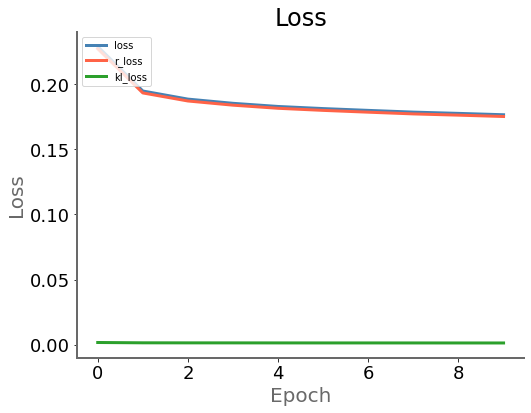

In [10]:
pwk.plot_history(history,  plot={"Loss":['loss','r_loss', 'kl_loss']}, save_as='history')

### 6.2 - Reconstruction during training
At the end of each epoch, our callback saved some reconstructed images.  
Where :  
Original image -> encoder -> z -> decoder -> Reconstructed image

<br>**Original images :**

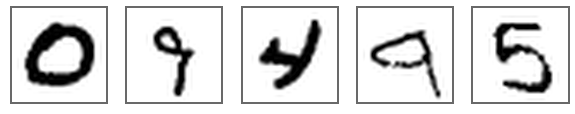

<br>**Encoded/decoded images**

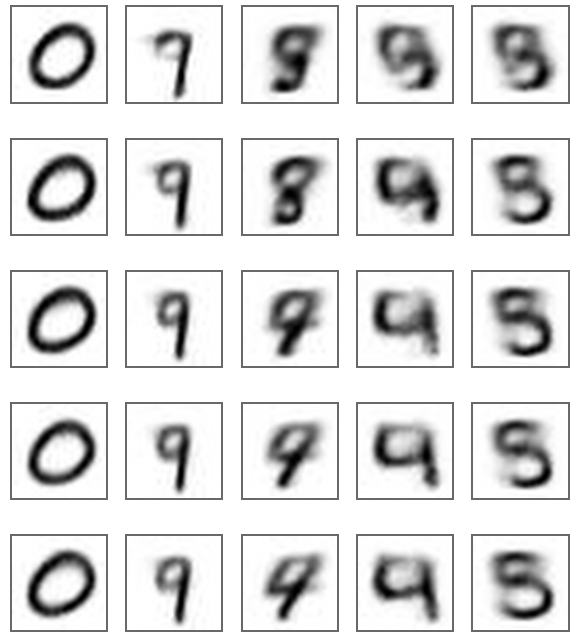

<br>**Original images :**

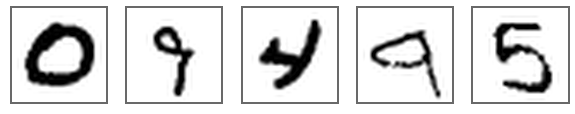

In [11]:
images_z, images_r = callback_images.get_images( range(0,epochs,2) )

pwk.subtitle('Original images :')
pwk.plot_images(x_data[:5], None, indices='all', columns=5, x_size=2,y_size=2, save_as=None)

pwk.subtitle('Encoded/decoded images')
pwk.plot_images(images_z, None, indices='all', columns=5, x_size=2,y_size=2, save_as='02-reconstruct')

pwk.subtitle('Original images :')
pwk.plot_images(x_data[:5], None, indices='all', columns=5, x_size=2,y_size=2, save_as=None)


### 6.3 - Generation (latent -> decoder)

<br>**Generated images from latent space**

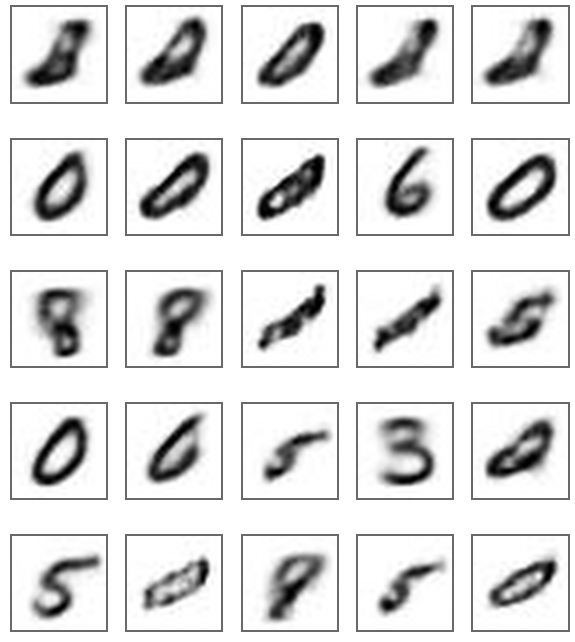

In [12]:
pwk.subtitle('Generated images from latent space')
pwk.plot_images(images_r, None, indices='all', columns=5, x_size=2,y_size=2, save_as='03-generated')

## Annexe - Model Save and reload 

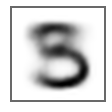

In [13]:
filename = run_dir+'/models/my_model.h5'

# ---- Save our model :

vae.save(filename)

# ---- Reload it

vae = keras.models.load_model(filename, custom_objects={'SamplingLayer': SamplingLayer, 'VariationalLossLayer':VariationalLossLayer})

# ---- Retrieve a layer

decoder = vae.get_layer('decoder')

img = decoder( np.array([[-1,.1]]))
pwk.plot_images(np.array(img), x_size=2,y_size=2, save_as='04-example')


In [14]:
pwk.end()

End time is : Monday 22 March 2021, 14:41:07
Duration is : 00:01:20 447ms
This notebook ends here


---
<img width="80px" src="../fidle/img/00-Fidle-logo-01.svg"></img>